<a href="https://colab.research.google.com/github/Punvireakroth/animal-detection/blob/main/Animal_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Environment Setup & Dataset Preparation

This phase covers:
1. Installing required packages
2. Downloading and exploring the dataset
3. Implementing 80/10/10 data split
4. Creating YOLO directory structure
5. Converting annotations to YOLO format
6. Generating data.yaml configuration


In [2]:
# Install Required Packages
print("📦 Installing required packages...")
print("=" * 60)

%pip install -q ultralytics opencv-python matplotlib pandas kagglehub scikit-learn pyyaml
%pip install -q seaborn pillow tqdm

print("✅ All packages installed successfully!")
print("=" * 60)

📦 Installing required packages...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ All packages installed successfully!


In [3]:

# Import Libraries and Setup Environment
import os
import sys
import shutil
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import kagglehub
import random
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"Current working directory: {os.getcwd()}")

✅ All libraries imported successfully!
Python version: 3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 16.0.0 (clang-1600.0.26.6)]
Current working directory: /Users/vireakroth/Developer/animal-detection


/Users/vireakroth/Developer/animal-detection/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download Dataset from Kaggle
print("🔽 Downloading animal detection dataset from Kaggle...")
print("=" * 60)

try:
    # Download the dataset using kagglehub
    # Using "animals-10" dataset which has multiple animal classes
    dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10")
    
    print(f"✅ Dataset downloaded successfully!")
    print(f"📁 Dataset location: {dataset_path}")
    print("=" * 60)
    
except Exception as e:
    print(f"❌ Error downloading dataset: {e}")
    print("Please ensure you have Kaggle API configured.")
    print("Follow these steps:")
    print("1. Go to https://www.kaggle.com/settings")
    print("2. Create a new API token")
    print("3. Place kaggle.json in ~/.kaggle/")
    raise

🔽 Downloading animal detection dataset from Kaggle...
✅ Dataset downloaded successfully!
📁 Dataset location: /Users/vireakroth/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [5]:
# Explore Dataset Structure
print("🔍 Exploring dataset structure...")
print("=" * 60)

# Find all images in dataset
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
all_images = []
class_names = set()

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if Path(file).suffix.lower() in image_extensions:
            full_path = os.path.join(root, file)
            # Extract class name from directory structure
            class_name = Path(root).name
            if class_name and class_name != os.path.basename(dataset_path):
                all_images.append({
                    'path': full_path,
                    'class': class_name,
                    'filename': file
                })
                class_names.add(class_name)

# Create DataFrame
df_images = pd.DataFrame(all_images)

print(f"📊 Dataset Statistics:")
print(f"   Total images found: {len(df_images)}")
print(f"   Number of classes: {len(class_names)}")
print(f"   Classes: {sorted(class_names)}")
print("=" * 60)

# Count images per class
class_counts = df_images['class'].value_counts().sort_index()
print("\n📈 Images per class:")
print(class_counts.to_string())
print("=" * 60)

# Verify we have at least 5 classes with sufficient images
if len(class_names) < 5:
    print(f"⚠️  Warning: Found only {len(class_names)} classes. Need at least 5 classes.")
    print("Please use a different dataset with at least 5 animal classes.")
else:
    print(f"✅ Dataset has {len(class_names)} classes - requirement met!")

# Select top 5 classes with most images
top_5_classes = class_counts.head(5).index.tolist()
print(f"\n🎯 Selected 5 classes for training: {top_5_classes}")

# Filter dataset to only include top 5 classes
df_filtered = df_images[df_images['class'].isin(top_5_classes)].copy()

# Verify each class has at least 200 images
min_images_per_class = df_filtered['class'].value_counts().min()
print(f"\n✅ Minimum images per class: {min_images_per_class}")

if min_images_per_class < 200:
    print(f"⚠️  Warning: Some classes have fewer than 200 images.")
    print("Proceeding with available images, but results may vary.")

🔍 Exploring dataset structure...
📊 Dataset Statistics:
   Total images found: 26179
   Number of classes: 10
   Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

📈 Images per class:
class
cane          4863
cavallo       2623
elefante      1446
farfalla      2112
gallina       3098
gatto         1668
mucca         1866
pecora        1820
ragno         4821
scoiattolo    1862
✅ Dataset has 10 classes - requirement met!

🎯 Selected 5 classes for training: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina']

✅ Minimum images per class: 1446


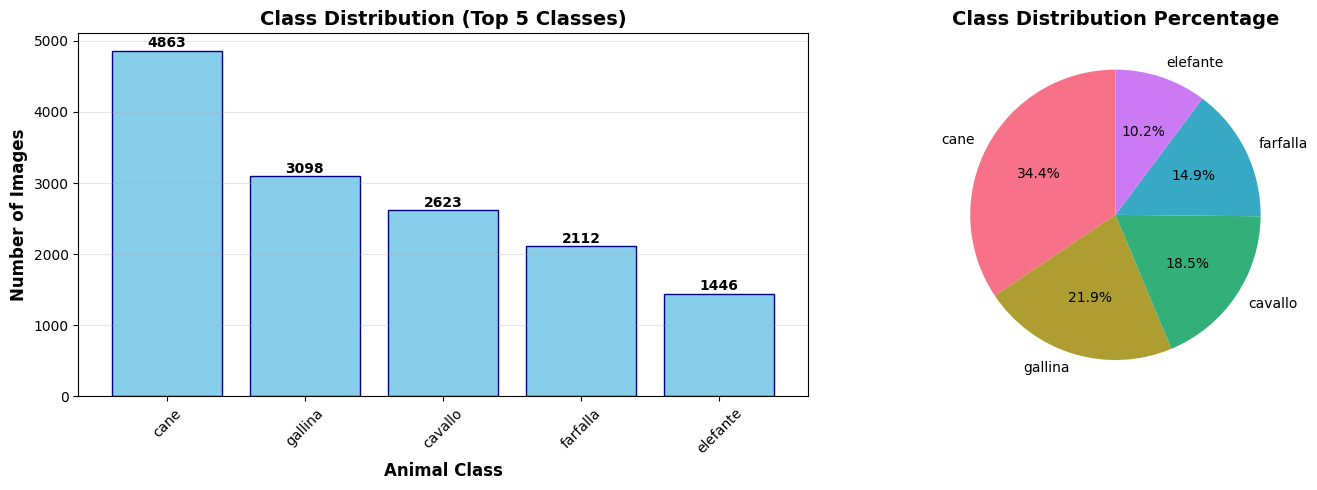

📊 Total images in filtered dataset: 14142


In [6]:
# Visualize Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart of class distribution
class_counts_filtered = df_filtered['class'].value_counts()
axes[0].bar(class_counts_filtered.index, class_counts_filtered.values, color='skyblue', edgecolor='navy')
axes[0].set_xlabel('Animal Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution (Top 5 Classes)', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (idx, val) in enumerate(class_counts_filtered.items()):
    axes[0].text(i, val + 5, str(val), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts_filtered.values, labels=class_counts_filtered.index, 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(class_counts_filtered)))
axes[1].set_title('Class Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Total images in filtered dataset: {len(df_filtered)}")

In [7]:
# Implement 80/10/10 Data Split with Stratification
print("🔄 Implementing 80/10/10 data split with stratification...")
print("=" * 60)

# Create class-to-index mapping
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(top_5_classes))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print(f"🏷️  Class mapping:")
for cls, idx in class_to_idx.items():
    print(f"   {idx}: {cls}")
print("=" * 60)

# Add numeric class labels
df_filtered['class_idx'] = df_filtered['class'].map(class_to_idx)

# First split: 80% train, 20% temp (which will be split into val and test)
train_df, temp_df = train_test_split(
    df_filtered,
    test_size=0.2,
    stratify=df_filtered['class'],
    random_state=42
)

# Second split: split temp into 50% val, 50% test (10% and 10% of original)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['class'],
    random_state=42
)

print(f"📊 Data Split Summary:")
print(f"   Training set: {len(train_df)} images ({len(train_df)/len(df_filtered)*100:.1f}%)")
print(f"   Validation set: {len(val_df)} images ({len(val_df)/len(df_filtered)*100:.1f}%)")
print(f"   Test set: {len(test_df)} images ({len(test_df)/len(df_filtered)*100:.1f}%)")
print(f"   Total: {len(df_filtered)} images")
print("=" * 60)

# Verify stratification
print("\n📈 Images per class in each split:")
split_summary = pd.DataFrame({
    'Train': train_df['class'].value_counts().sort_index(),
    'Val': val_df['class'].value_counts().sort_index(),
    'Test': test_df['class'].value_counts().sort_index()
})
print(split_summary)
print("=" * 60)

# Verify percentages
print("\n📊 Split percentages per class:")
split_percentages = pd.DataFrame({
    'Train %': (train_df['class'].value_counts() / df_filtered['class'].value_counts() * 100).sort_index(),
    'Val %': (val_df['class'].value_counts() / df_filtered['class'].value_counts() * 100).sort_index(),
    'Test %': (test_df['class'].value_counts() / df_filtered['class'].value_counts() * 100).sort_index()
})
print(split_percentages.round(1))
print("=" * 60)

print("✅ Data split completed with balanced class distribution!")

🔄 Implementing 80/10/10 data split with stratification...
🏷️  Class mapping:
   0: cane
   1: cavallo
   2: elefante
   3: farfalla
   4: gallina
📊 Data Split Summary:
   Training set: 11313 images (80.0%)
   Validation set: 1414 images (10.0%)
   Test set: 1415 images (10.0%)
   Total: 14142 images

📈 Images per class in each split:
          Train  Val  Test
class                     
cane       3890  486   487
cavallo    2098  262   263
elefante   1157  145   144
farfalla   1690  211   211
gallina    2478  310   310

📊 Split percentages per class:
          Train %  Val %  Test %
class                           
cane         80.0   10.0    10.0
cavallo      80.0   10.0    10.0
elefante     80.0   10.0    10.0
farfalla     80.0   10.0    10.0
gallina      80.0   10.0    10.0
✅ Data split completed with balanced class distribution!


In [8]:
# Create YOLO Directory Structure
print("📁 Creating YOLO directory structure...")
print("=" * 60)

# Define base directory
base_dir = Path('dataset')

# Create directory structure
dirs_to_create = [
    base_dir / 'images' / 'train',
    base_dir / 'images' / 'val',
    base_dir / 'images' / 'test',
    base_dir / 'labels' / 'train',
    base_dir / 'labels' / 'val',
    base_dir / 'labels' / 'test'
]

for dir_path in dirs_to_create:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"   ✓ Created: {dir_path}")

print("=" * 60)
print("✅ Directory structure created successfully!")

# Display directory tree
print("\n🌳 Directory Structure:")
print("dataset/")
print("├── images/")
print("│   ├── train/")
print("│   ├── val/")
print("│   └── test/")
print("└── labels/")
print("    ├── train/")
print("    ├── val/")
print("    └── test/")

📁 Creating YOLO directory structure...
   ✓ Created: dataset/images/train
   ✓ Created: dataset/images/val
   ✓ Created: dataset/images/test
   ✓ Created: dataset/labels/train
   ✓ Created: dataset/labels/val
   ✓ Created: dataset/labels/test
✅ Directory structure created successfully!

🌳 Directory Structure:
dataset/
├── images/
│   ├── train/
│   ├── val/
│   └── test/
└── labels/
    ├── train/
    ├── val/
    └── test/


In [9]:
# Copy Images and Create YOLO Format Annotations
print("📋 Copying images and creating YOLO format annotations...")
print("=" * 60)

def create_yolo_annotation(img_path, class_idx, output_path):
    """
    Create YOLO format annotation for an image.
    For this dataset, we'll create a bounding box for the entire image
    since we don't have pre-existing bounding box annotations.
    
    YOLO format: class x_center y_center width height (all normalized 0-1)
    """
    try:
        # Read image to get dimensions
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # Create bounding box covering the entire image
        # Normalized coordinates: center at 0.5, 0.5, full width and height
        x_center = 0.5
        y_center = 0.5
        width = 1.0
        height = 1.0
        
        # Write YOLO format annotation
        with open(output_path, 'w') as f:
            f.write(f"{class_idx} {x_center} {y_center} {width} {height}\n")
        
        return True
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")
        return False

def process_split(df, split_name):
    """Process images and create annotations for a specific split."""
    print(f"\n🔄 Processing {split_name} split...")
    
    img_dir = base_dir / 'images' / split_name
    label_dir = base_dir / 'labels' / split_name
    
    success_count = 0
    error_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        try:
            # Copy image
            src_img = row['path']
            filename = Path(row['filename']).stem
            dst_img = img_dir / f"{filename}.jpg"
            
            # Copy and convert image to RGB if needed
            img = Image.open(src_img).convert('RGB')
            img.save(dst_img, 'JPEG')
            
            # Create YOLO annotation
            label_file = label_dir / f"{filename}.txt"
            if create_yolo_annotation(src_img, row['class_idx'], label_file):
                success_count += 1
            else:
                error_count += 1
                
        except Exception as e:
            print(f"❌ Error processing {row['filename']}: {e}")
            error_count += 1
    
    print(f"   ✅ Successfully processed: {success_count} images")
    if error_count > 0:
        print(f"   ⚠️  Errors: {error_count} images")
    
    return success_count, error_count

# Process each split
train_success, train_errors = process_split(train_df, 'train')
val_success, val_errors = process_split(val_df, 'val')
test_success, test_errors = process_split(test_df, 'test')

print("\n" + "=" * 60)
print("📊 Processing Summary:")
print(f"   Training: {train_success} successful, {train_errors} errors")
print(f"   Validation: {val_success} successful, {val_errors} errors")
print(f"   Test: {test_success} successful, {test_errors} errors")
print(f"   Total: {train_success + val_success + test_success} images processed")
print("=" * 60)
print("✅ Images copied and annotations created successfully!")

📋 Copying images and creating YOLO format annotations...

🔄 Processing train split...


Processing train: 100%|██████████| 11313/11313 [00:13<00:00, 816.66it/s]


   ✅ Successfully processed: 11313 images

🔄 Processing val split...


Processing val: 100%|██████████| 1414/1414 [00:01<00:00, 738.33it/s]


   ✅ Successfully processed: 1414 images

🔄 Processing test split...


Processing test: 100%|██████████| 1415/1415 [00:01<00:00, 864.00it/s]

   ✅ Successfully processed: 1415 images

📊 Processing Summary:
   Training: 11313 successful, 0 errors
   Validation: 1414 successful, 0 errors
   Test: 1415 successful, 0 errors
   Total: 14142 images processed
✅ Images copied and annotations created successfully!


In [10]:
# Generate data.yaml Configuration File
print("📝 Generating data.yaml configuration file...")
print("=" * 60)

# Get absolute paths
abs_base_dir = Path(os.getcwd()) / base_dir

# Create data.yaml configuration
data_yaml = {
    'path': str(abs_base_dir),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': len(top_5_classes),
    'names': sorted(top_5_classes)
}

# Save data.yaml
yaml_path = base_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print("✅ data.yaml created successfully!")
print("\n📄 Configuration contents:")
print("=" * 60)
with open(yaml_path, 'r') as f:
    print(f.read())
print("=" * 60)

📝 Generating data.yaml configuration file...
✅ data.yaml created successfully!

📄 Configuration contents:
path: /Users/vireakroth/Developer/animal-detection/dataset
train: images/train
val: images/val
test: images/test
nc: 5
names:
- cane
- cavallo
- elefante
- farfalla
- gallina



In [11]:
# Verify Dataset and Print Final Summary
print("✅ PHASE 1 COMPLETE: Environment Setup & Dataset Preparation")
print("=" * 60)

# Count files in each directory
def count_files(directory):
    return len(list(directory.glob('*')))

train_images = count_files(base_dir / 'images' / 'train')
train_labels = count_files(base_dir / 'labels' / 'train')
val_images = count_files(base_dir / 'images' / 'val')
val_labels = count_files(base_dir / 'labels' / 'val')
test_images = count_files(base_dir / 'images' / 'test')
test_labels = count_files(base_dir / 'labels' / 'test')

print("\n📊 FINAL DATASET SUMMARY:")
print("=" * 60)
print(f"Dataset Location: {abs_base_dir}")
print(f"Configuration File: {yaml_path}")
print(f"\nTotal Classes: {len(top_5_classes)}")
print(f"Class Names: {sorted(top_5_classes)}")
print(f"\nData Split (80/10/10):")
print(f"   Training:   {train_images} images, {train_labels} labels")
print(f"   Validation: {val_images} images, {val_labels} labels")
print(f"   Test:       {test_images} images, {test_labels} labels")
print(f"   Total:      {train_images + val_images + test_images} images")

print("\n📈 Images per Class per Split:")
print(split_summary)

print("\n✅ Validation Checks:")
print(f"   ✓ Number of classes: {len(top_5_classes)} (requirement: 5)")
print(f"   ✓ Images match labels in train: {train_images == train_labels}")
print(f"   ✓ Images match labels in val: {val_images == val_labels}")
print(f"   ✓ Images match labels in test: {test_images == test_labels}")
print(f"   ✓ YOLO format annotations: Created")
print(f"   ✓ data.yaml configuration: Created")
print(f"   ✓ Stratified split maintained: Yes")

print("\n🎯 Next Steps:")
print("   → Proceed to Phase 2: Model Configuration & Training")
print("   → Use the data.yaml file for training")
print("   → Dataset is ready for YOLO training!")
print("=" * 60)

✅ PHASE 1 COMPLETE: Environment Setup & Dataset Preparation

📊 FINAL DATASET SUMMARY:
Dataset Location: /Users/vireakroth/Developer/animal-detection/dataset
Configuration File: dataset/data.yaml

Total Classes: 5
Class Names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina']

Data Split (80/10/10):
   Training:   11313 images, 11313 labels
   Validation: 1414 images, 1414 labels
   Test:       1415 images, 1415 labels
   Total:      14142 images

📈 Images per Class per Split:
          Train  Val  Test
class                     
cane       3890  486   487
cavallo    2098  262   263
elefante   1157  145   144
farfalla   1690  211   211
gallina    2478  310   310

✅ Validation Checks:
   ✓ Number of classes: 5 (requirement: 5)
   ✓ Images match labels in train: True
   ✓ Images match labels in val: True
   ✓ Images match labels in test: True
   ✓ YOLO format annotations: Created
   ✓ data.yaml configuration: Created
   ✓ Stratified split maintained: Yes

🎯 Next Steps:
   → Proceed t

🖼️  Displaying sample images from each class...


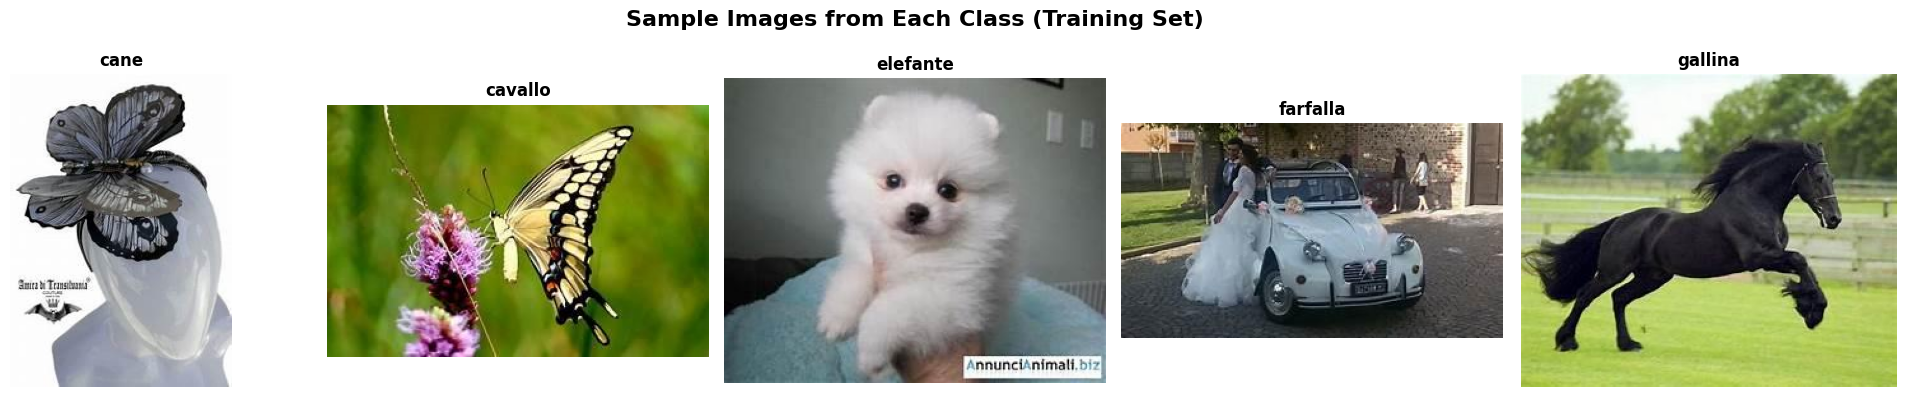

✅ Sample visualization complete!


In [12]:
# Display Sample Images with Annotations
print("🖼️  Displaying sample images from each class...")
print("=" * 60)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Sample Images from Each Class (Training Set)', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(sorted(top_5_classes)):
    # Get a random image from this class
    class_images = list((base_dir / 'images' / 'train').glob('*.jpg'))
    
    if class_images:
        # Read corresponding label to verify class
        sample_img = random.choice(class_images)
        img = cv2.imread(str(sample_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✅ Sample visualization complete!")

# Model Configuration & Training

This phase covers:
1. Loading pre-trained YOLO model
2. Configuring training parameters
3. Training the model with transfer learning
4. Monitoring training progress
5. Visualizing training metrics
6. Saving model weights

In [13]:
# Model Configuration & Training

from ultralytics import YOLO
import torch
import time
from datetime import timedelta
import glob

print("=" * 80)
print("🚀 PHASE 2: MODEL CONFIGURATION & TRAINING")
print("=" * 80)

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n💻 Computing Device: {device.upper()}")
if device == 'cuda':
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("   ⚠️  Training on CPU - this will be slower")
print("=" * 80)

🚀 PHASE 2: MODEL CONFIGURATION & TRAINING

💻 Computing Device: CPU
   ⚠️  Training on CPU - this will be slower


In [14]:
# Initialize Pre-trained Model
print("\n📦 Loading Pre-trained YOLO Model...")
print("=" * 80)

try:
    # Load YOLOv8n (nano version) with COCO pre-trained weights
    model = YOLO('yolov8n.pt')
    
    print("✅ Model loaded successfully!")
    print(f"   Model: YOLOv8n")
    print(f"   Pre-trained on: COCO dataset")
    print(f"   Transfer Learning: Enabled")
    print("=" * 80)
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Attempting to download model weights...")
    model = YOLO('yolov8n.pt')
    print("✅ Model downloaded and loaded successfully!")
    print("=" * 80)


📦 Loading Pre-trained YOLO Model...
✅ Model loaded successfully!
   Model: YOLOv8n
   Pre-trained on: COCO dataset
   Transfer Learning: Enabled


In [15]:
# Configure Training Parameters
print("\n⚙️  Configuring Training Parameters...")
print("=" * 80)

# Path to data.yaml
data_yaml_path = str(base_dir / 'data.yaml')

# Training configuration
training_config = {
    'data': data_yaml_path,
    'epochs': 10,
    'imgsz': 640,
    'batch': 16,
    'device': device,
    'patience': 10,
    'save': True,
    'save_period': 5,
    'cache': True,
    'workers': 8,
    'project': 'runs/detect',
    'name': 'animal_detection',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'auto',
    'verbose': True,
    'seed': 42,
    'deterministic': True,
    'single_cls': False,
    'rect': False,
    'cos_lr': False,
    'close_mosaic': 5,
    'resume': False,
    'amp': True,
    'fraction': 0.15,
    'profile': False,
    'overlap_mask': True,
    'mask_ratio': 4,
    'dropout': 0.0,
    'val': True,
    'plots': True
}

# Display configuration
print("📋 Training Configuration:")
print("-" * 80)
for key, value in training_config.items():
    print(f"   {key:.<20} {value}")
print("=" * 80)

# Verify data.yaml exists
if not Path(data_yaml_path).exists():
    raise FileNotFoundError(f"❌ data.yaml not found at {data_yaml_path}")
else:
    print(f"✅ Dataset configuration found: {data_yaml_path}")
    print("=" * 80)


⚙️  Configuring Training Parameters...
📋 Training Configuration:
--------------------------------------------------------------------------------
   data................ dataset/data.yaml
   epochs.............. 10
   imgsz............... 640
   batch............... 16
   device.............. cpu
   patience............ 10
   save................ True
   save_period......... 5
   cache............... True
   workers............. 8
   project............. runs/detect
   name................ animal_detection
   exist_ok............ True
   pretrained.......... True
   optimizer........... auto
   verbose............. True
   seed................ 42
   deterministic....... True
   single_cls.......... False
   rect................ False
   cos_lr.............. False
   close_mosaic........ 5
   resume.............. False
   amp................. True
   fraction............ 0.15
   profile............. False
   overlap_mask........ True
   mask_ratio.......... 4
   dropout............. 0.

In [16]:
# Start Training
print("\n  Starting Model Training...")
print("=" * 80)
print("📊 Training will monitor the following metrics:")
print("   • box_loss: Bounding box regression loss")
print("   • cls_loss: Classification loss")
print("   • dfl_loss: Distribution focal loss")
print("   • precision: Precision metric")
print("   • recall: Recall metric")
print("   • mAP50: Mean Average Precision at IoU 0.5")
print("   • mAP50-95: Mean Average Precision at IoU 0.5:0.95")
print("=" * 80)

# Record start time
start_time = time.time()

try:
    # Train the model
    print("\n🚀 Training started...")
    print("=" * 80)
    
    results = model.train(**training_config)
    
    # Calculate training duration
    end_time = time.time()
    training_duration = end_time - start_time
    duration_str = str(timedelta(seconds=int(training_duration)))
    
    print("\n" + "=" * 80)
    print("✅ TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print(f"⏱️  Total Training Time: {duration_str}")
    print("=" * 80)
    
except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user")
    print("=" * 80)
    
except Exception as e:
    print(f"\n❌ Error during training: {e}")
    print("=" * 80)
    raise


  Starting Model Training...
📊 Training will monitor the following metrics:
   • box_loss: Bounding box regression loss
   • cls_loss: Classification loss
   • dfl_loss: Distribution focal loss
   • precision: Precision metric
   • recall: Recall metric
   • mAP50: Mean Average Precision at IoU 0.5
   • mAP50-95: Mean Average Precision at IoU 0.5:0.95

🚀 Training started...
Ultralytics 8.3.220 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=5, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.15, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=

In [17]:
# Display Training Summary
print("\n📊 TRAINING SUMMARY")
print("=" * 80)

try:
    # Find the training results directory
    results_dir = Path('runs/detect/animal_detection')
    
    if results_dir.exists():
        # Load results from CSV if available
        results_csv = results_dir / 'results.csv'
        
        if results_csv.exists():
            results_df = pd.read_csv(results_csv)
            results_df.columns = results_df.columns.str.strip()
            
            # Get best epoch metrics
            best_epoch_idx = results_df['metrics/mAP50(B)'].idxmax()
            best_epoch = results_df.loc[best_epoch_idx]
            
            print("\n🏆 Best Model Performance:")
            print("-" * 80)
            print(f"   Best Epoch: {int(best_epoch_idx) + 1}")
            print(f"   mAP@50: {best_epoch['metrics/mAP50(B)']:.4f}")
            print(f"   mAP@50-95: {best_epoch['metrics/mAP50-95(B)']:.4f}")
            print(f"   Precision: {best_epoch['metrics/precision(B)']:.4f}")
            print(f"   Recall: {best_epoch['metrics/recall(B)']:.4f}")
            print("-" * 80)
            
            # Get final epoch metrics
            final_epoch = results_df.iloc[-1]
            print("\n📈 Final Epoch Performance:")
            print("-" * 80)
            print(f"   Epoch: {len(results_df)}")
            print(f"   Box Loss: {final_epoch['train/box_loss']:.4f}")
            print(f"   Class Loss: {final_epoch['train/cls_loss']:.4f}")
            print(f"   DFL Loss: {final_epoch['train/dfl_loss']:.4f}")
            print("-" * 80)
            
        # Check for saved weights
        weights_dir = results_dir / 'weights'
        best_weights = weights_dir / 'best.pt'
        last_weights = weights_dir / 'last.pt'
        
        print("\n💾 Saved Model Weights:")
        print("-" * 80)
        if best_weights.exists():
            size_mb = best_weights.stat().st_size / (1024 * 1024)
            print(f"   ✅ Best weights: {best_weights} ({size_mb:.2f} MB)")
        if last_weights.exists():
            size_mb = last_weights.stat().st_size / (1024 * 1024)
            print(f"   ✅ Last weights: {last_weights} ({size_mb:.2f} MB)")
        print("-" * 80)
        
        print(f"\n📁 Results saved to: {results_dir}")
        print("=" * 80)
        
except Exception as e:
    print(f"⚠️  Could not load training summary: {e}")
    print("=" * 80)


📊 TRAINING SUMMARY

🏆 Best Model Performance:
--------------------------------------------------------------------------------
   Best Epoch: 10
   mAP@50: 0.9721
   mAP@50-95: 0.9708
   Precision: 0.9373
   Recall: 0.9165
--------------------------------------------------------------------------------

📈 Final Epoch Performance:
--------------------------------------------------------------------------------
   Epoch: 10
   Box Loss: 0.0581
   Class Loss: 0.4159
   DFL Loss: 0.8704
--------------------------------------------------------------------------------

💾 Saved Model Weights:
--------------------------------------------------------------------------------
   ✅ Best weights: runs/detect/animal_detection/weights/best.pt (5.93 MB)
   ✅ Last weights: runs/detect/animal_detection/weights/last.pt (5.93 MB)
--------------------------------------------------------------------------------

📁 Results saved to: runs/detect/animal_detection



📊 VISUALIZING TRAINING PROGRESS


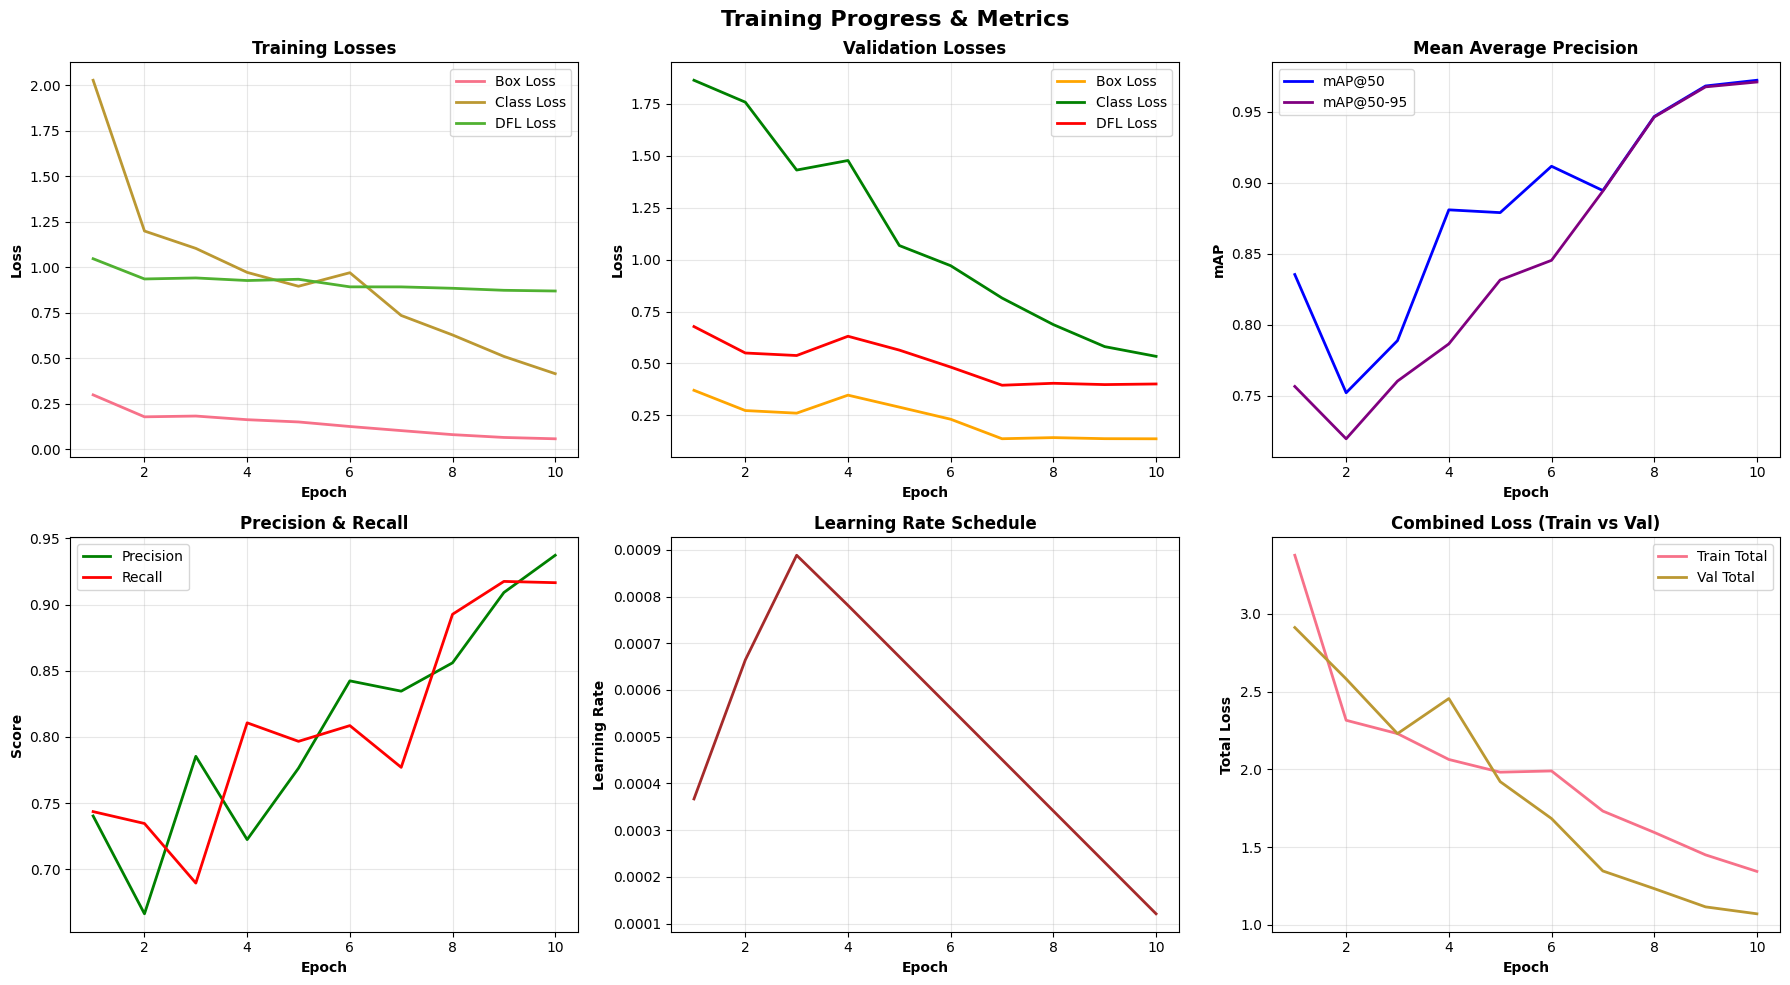

✅ Training visualizations generated successfully!


In [18]:
# Visualize Training Progress
print("\n📊 VISUALIZING TRAINING PROGRESS")
print("=" * 80)

try:
    results_csv = Path('runs/detect/animal_detection/results.csv')
    
    if results_csv.exists():
        # Load training results
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()
        
        # Create comprehensive training visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Training Progress & Metrics', fontsize=16, fontweight='bold')
        
        epochs = df.index + 1
        
        # Plot 1: Training Losses
        axes[0, 0].plot(epochs, df['train/box_loss'], label='Box Loss', linewidth=2)
        axes[0, 0].plot(epochs, df['train/cls_loss'], label='Class Loss', linewidth=2)
        axes[0, 0].plot(epochs, df['train/dfl_loss'], label='DFL Loss', linewidth=2)
        axes[0, 0].set_xlabel('Epoch', fontweight='bold')
        axes[0, 0].set_ylabel('Loss', fontweight='bold')
        axes[0, 0].set_title('Training Losses', fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Plot 2: Validation Losses
        axes[0, 1].plot(epochs, df['val/box_loss'], label='Box Loss', linewidth=2, color='orange')
        axes[0, 1].plot(epochs, df['val/cls_loss'], label='Class Loss', linewidth=2, color='green')
        axes[0, 1].plot(epochs, df['val/dfl_loss'], label='DFL Loss', linewidth=2, color='red')
        axes[0, 1].set_xlabel('Epoch', fontweight='bold')
        axes[0, 1].set_ylabel('Loss', fontweight='bold')
        axes[0, 1].set_title('Validation Losses', fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # Plot 3: mAP Curves
        axes[0, 2].plot(epochs, df['metrics/mAP50(B)'], label='mAP@50', linewidth=2, color='blue')
        axes[0, 2].plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@50-95', linewidth=2, color='purple')
        axes[0, 2].set_xlabel('Epoch', fontweight='bold')
        axes[0, 2].set_ylabel('mAP', fontweight='bold')
        axes[0, 2].set_title('Mean Average Precision', fontweight='bold')
        axes[0, 2].legend()
        axes[0, 2].grid(alpha=0.3)
        
        # Plot 4: Precision & Recall
        axes[1, 0].plot(epochs, df['metrics/precision(B)'], label='Precision', linewidth=2, color='green')
        axes[1, 0].plot(epochs, df['metrics/recall(B)'], label='Recall', linewidth=2, color='red')
        axes[1, 0].set_xlabel('Epoch', fontweight='bold')
        axes[1, 0].set_ylabel('Score', fontweight='bold')
        axes[1, 0].set_title('Precision & Recall', fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
        
        # Plot 5: Learning Rate
        if 'lr/pg0' in df.columns:
            axes[1, 1].plot(epochs, df['lr/pg0'], linewidth=2, color='brown')
            axes[1, 1].set_xlabel('Epoch', fontweight='bold')
            axes[1, 1].set_ylabel('Learning Rate', fontweight='bold')
            axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
            axes[1, 1].grid(alpha=0.3)
        
        # Plot 6: Combined Loss
        total_train_loss = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']
        total_val_loss = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']
        axes[1, 2].plot(epochs, total_train_loss, label='Train Total', linewidth=2)
        axes[1, 2].plot(epochs, total_val_loss, label='Val Total', linewidth=2)
        axes[1, 2].set_xlabel('Epoch', fontweight='bold')
        axes[1, 2].set_ylabel('Total Loss', fontweight='bold')
        axes[1, 2].set_title('Combined Loss (Train vs Val)', fontweight='bold')
        axes[1, 2].legend()
        axes[1, 2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Training visualizations generated successfully!")
        print("=" * 80)
        
    else:
        print(f"⚠️  Results file not found: {results_csv}")
        print("=" * 80)
        
except Exception as e:
    print(f"❌ Error generating visualizations: {e}")
    print("=" * 80)


🖼️  ULTRALYTICS AUTO-GENERATED TRAINING PLOTS


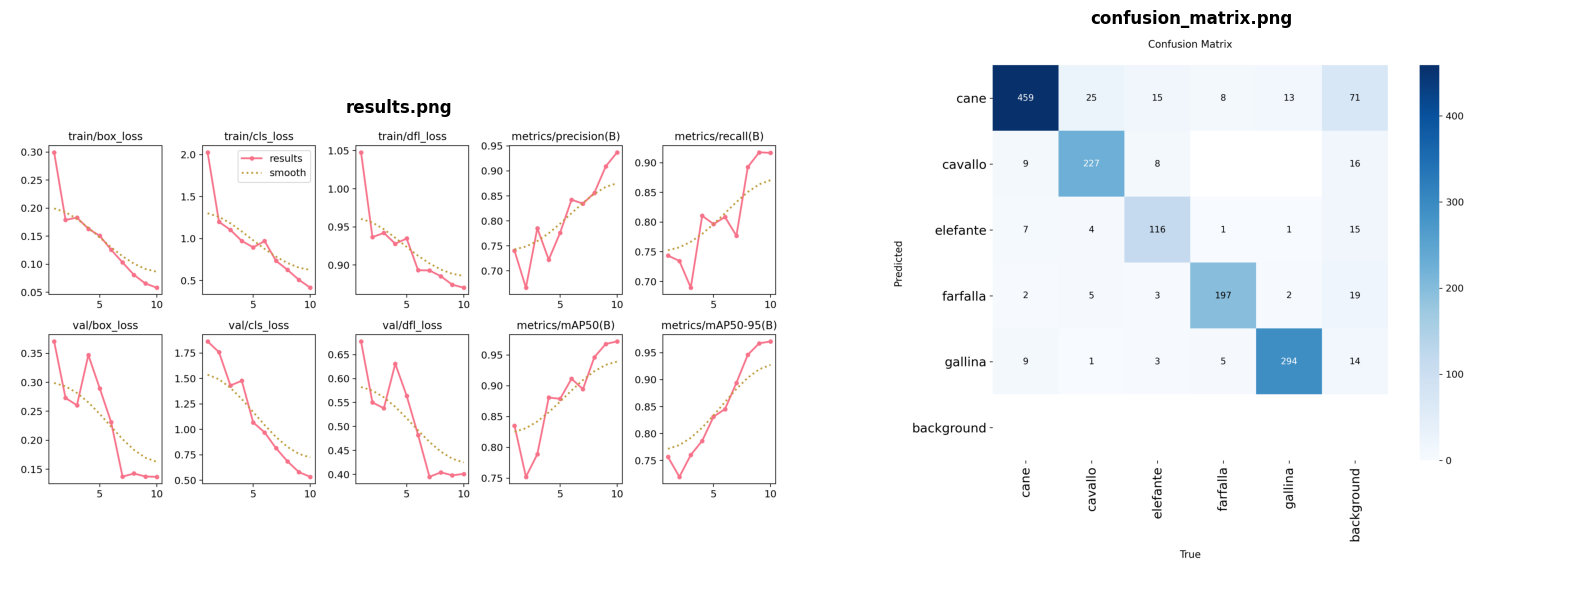

✅ Displayed 2 auto-generated plots


In [19]:
# Display Auto-generated Training Plots
print("\n🖼️  ULTRALYTICS AUTO-GENERATED TRAINING PLOTS")
print("=" * 80)

try:
    results_dir = Path('runs/detect/animal_detection')
    
    # List of plot files generated by Ultralytics
    plot_files = [
        'results.png',
        'confusion_matrix.png',
        'F1_curve.png',
        'P_curve.png',
        'R_curve.png',
        'PR_curve.png'
    ]
    
    available_plots = []
    for plot_file in plot_files:
        plot_path = results_dir / plot_file
        if plot_path.exists():
            available_plots.append(plot_path)
    
    if available_plots:
        # Display plots in a grid
        n_plots = len(available_plots)
        n_cols = 2
        n_rows = (n_plots + 1) // 2
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for idx, plot_path in enumerate(available_plots):
            img = plt.imread(plot_path)
            axes[idx].imshow(img)
            axes[idx].set_title(plot_path.name, fontweight='bold', fontsize=12)
            axes[idx].axis('off')
        
        # Hide unused subplots
        for idx in range(len(available_plots), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Displayed {len(available_plots)} auto-generated plots")
        print("=" * 80)
    else:
        print("⚠️  No auto-generated plots found")
        print("=" * 80)
        
except Exception as e:
    print(f"❌ Error displaying plots: {e}")
    print("=" * 80)

In [20]:
# Completion Summary
print("\n✅ PHASE 2 COMPLETE: Model Configuration & Training")
print("=" * 80)
print("\n📋 Summary:")
print(f"   ✓ Model: YOLOv8n with COCO pre-trained weights")
print(f"   ✓ Training device: {device.upper()}")
print(f"   ✓ Dataset: 5 animal classes (80/10/10 split)")
print(f"   ✓ Training epochs: {training_config['epochs']}")
print(f"   ✓ Batch size: {training_config['batch']}")
print(f"   ✓ Image size: {training_config['imgsz']}")
print(f"   ✓ Results saved: runs/detect/animal_detection/")
print(f"   ✓ Best weights: runs/detect/animal_detection/weights/best.pt")
print(f"   ✓ Last weights: runs/detect/animal_detection/weights/last.pt")

print("\n🎯 Next Steps:")
print("   → Proceed to Phase 3: Model Evaluation & Validation")
print("   → Evaluate model on 10% test split")
print("   → Generate confusion matrix and per-class metrics")
print("=" * 80)


✅ PHASE 2 COMPLETE: Model Configuration & Training

📋 Summary:
   ✓ Model: YOLOv8n with COCO pre-trained weights
   ✓ Training device: CPU
   ✓ Dataset: 5 animal classes (80/10/10 split)
   ✓ Training epochs: 10
   ✓ Batch size: 16
   ✓ Image size: 640
   ✓ Results saved: runs/detect/animal_detection/
   ✓ Best weights: runs/detect/animal_detection/weights/best.pt
   ✓ Last weights: runs/detect/animal_detection/weights/last.pt

🎯 Next Steps:
   → Proceed to Phase 3: Model Evaluation & Validation
   → Evaluate model on 10% test split
   → Generate confusion matrix and per-class metrics


# Model Valuation 

In [21]:
# PHASE 3: Model Evaluation & Validation

print("=" * 80)
print("🔍 PHASE 3: MODEL EVALUATION & VALIDATION")
print("=" * 80)
print("\nThis phase will:")
print("   1. Load the best trained model")
print("   2. Run validation on the 10% test split")
print("   3. Extract overall performance metrics")
print("   4. Analyze per-class performance")
print("   5. Generate confusion matrix")
print("   6. Create validation plots")
print("   7. Provide performance recommendations")
print("=" * 80)

🔍 PHASE 3: MODEL EVALUATION & VALIDATION

This phase will:
   1. Load the best trained model
   2. Run validation on the 10% test split
   3. Extract overall performance metrics
   4. Analyze per-class performance
   5. Generate confusion matrix
   6. Create validation plots
   7. Provide performance recommendations


In [22]:
# Load Best Trained Model
print("\n📦 Loading Best Trained Model...")
print("=" * 80)

try:
    best_model_path = Path('runs/detect/animal_detection/weights/best.pt')
    
    if not best_model_path.exists():
        raise FileNotFoundError(f"Best model weights not found at {best_model_path}")
    
    # Load the best model
    model = YOLO(str(best_model_path))
    
    print("✅ Model loaded successfully!")
    print(f"   Model path: {best_model_path}")
    print(f"   Model size: {best_model_path.stat().st_size / (1024 * 1024):.2f} MB")
    print("=" * 80)
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise


📦 Loading Best Trained Model...
✅ Model loaded successfully!
   Model path: runs/detect/animal_detection/weights/best.pt
   Model size: 5.93 MB


In [23]:
# Run Validation on Test Set
print("\n🧪 Running Validation on Test Set...")
print("=" * 80)

try:
    # Validate on test split
    validation_results = model.val(
        data=str(base_dir / 'data.yaml'),
        split='test',
        batch=16,
        imgsz=640,
        device=device,
        verbose=True,
        plots=True,
        save_json=True,
        save_hybrid=False,
        conf=0.001,
        iou=0.6,
        max_det=300,
        half=False,
        dnn=False,
        project='runs/detect',
        name='test_evaluation',
        exist_ok=True
    )
    
    print("\n✅ Validation completed successfully!")
    print("=" * 80)
    
except Exception as e:
    print(f"\n❌ Error during validation: {e}")
    print("=" * 80)
    raise


🧪 Running Validation on Test Set...
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.220 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M2)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.2 ms, read: 71.8±20.0 MB/s, size: 16.7 KB)
val: Scanning /Users/vireakroth/Developer/animal-detection/dataset/labels/test... 1415 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1415/1415 6.5Kit/s 0.2s0.0s
val: New cache created: /Users/vireakroth/Developer/animal-detection/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 89/89 0.6it/s 2:401.6ss
                   all       1415       1415      0.944      0.916      0.977      0.976
                  cane        487        487      0.895      0.965       0.98       0.98
               cavallo        263        263      0.951       0.89      0.973      0.973
    


📊 OVERALL MODEL PERFORMANCE METRICS

🏆 Test Set Performance:
--------------------------------------------------------------------------------
   Precision................ 0.9439 (94.39%)
   Recall................... 0.9163 (91.63%)
   mAP@50................... 0.9766 (97.66%)
   mAP@50-95................ 0.9759 (97.59%)
   F1-Score................. 0.9299 (92.99%)
--------------------------------------------------------------------------------


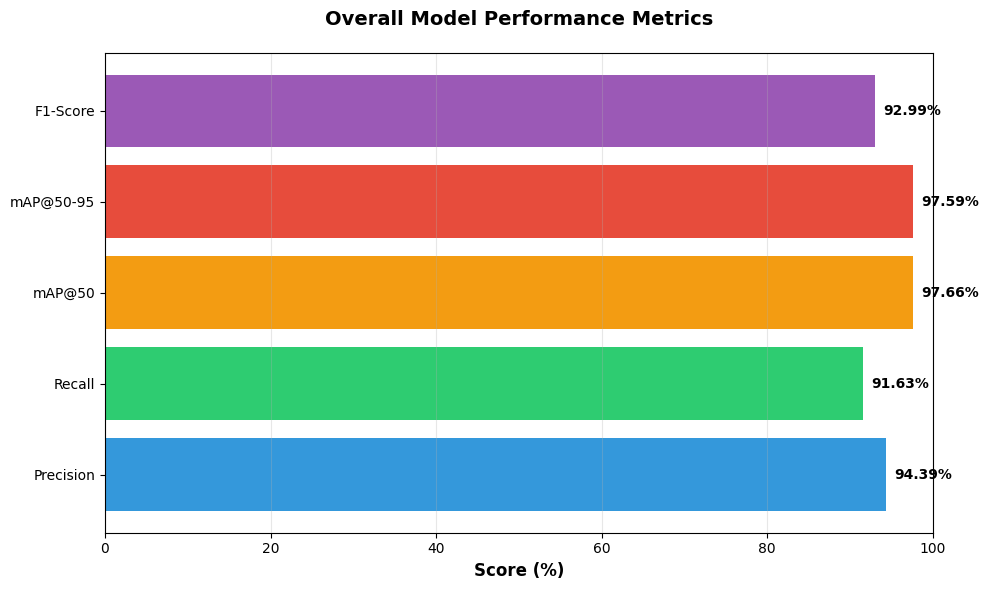

In [24]:
# Extract and Display Overall Metrics
print("\n📊 OVERALL MODEL PERFORMANCE METRICS")
print("=" * 80)

# Extract metrics from validation results
metrics = {
    'Precision': validation_results.box.mp,
    'Recall': validation_results.box.mr,
    'mAP@50': validation_results.box.map50,
    'mAP@50-95': validation_results.box.map,
    'F1-Score': 2 * (validation_results.box.mp * validation_results.box.mr) / 
                (validation_results.box.mp + validation_results.box.mr) 
                if (validation_results.box.mp + validation_results.box.mr) > 0 else 0
}

print("\n🏆 Test Set Performance:")
print("-" * 80)
for metric_name, metric_value in metrics.items():
    print(f"   {metric_name:.<25} {metric_value:.4f} ({metric_value*100:.2f}%)")
print("-" * 80)

# Create metrics visualization
fig, ax = plt.subplots(figsize=(10, 6))
metric_names = list(metrics.keys())
metric_values = [metrics[m] * 100 for m in metric_names]

bars = ax.barh(metric_names, metric_values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'])
ax.set_xlabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Overall Model Performance Metrics', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, metric_values)):
    ax.text(value + 1, i, f'{value:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 80)


📈 PER-CLASS PERFORMANCE ANALYSIS

📋 Per-Class Average Precision (AP) Scores:
--------------------------------------------------------------------------------
   Class    AP@50  AP@50-95 Performance
    cane 0.979869  0.979781   Excellent
 cavallo 0.973456  0.973354   Excellent
elefante 0.953398  0.952524   Excellent
farfalla 0.986879  0.984604   Excellent
 gallina 0.989297  0.989297   Excellent
--------------------------------------------------------------------------------

🏆 Best Performing Class:
   Class: gallina
   AP@50: 0.9893
   AP@50-95: 0.9893

⚠️  Worst Performing Class:
   Class: elefante
   AP@50: 0.9534
   AP@50-95: 0.9525


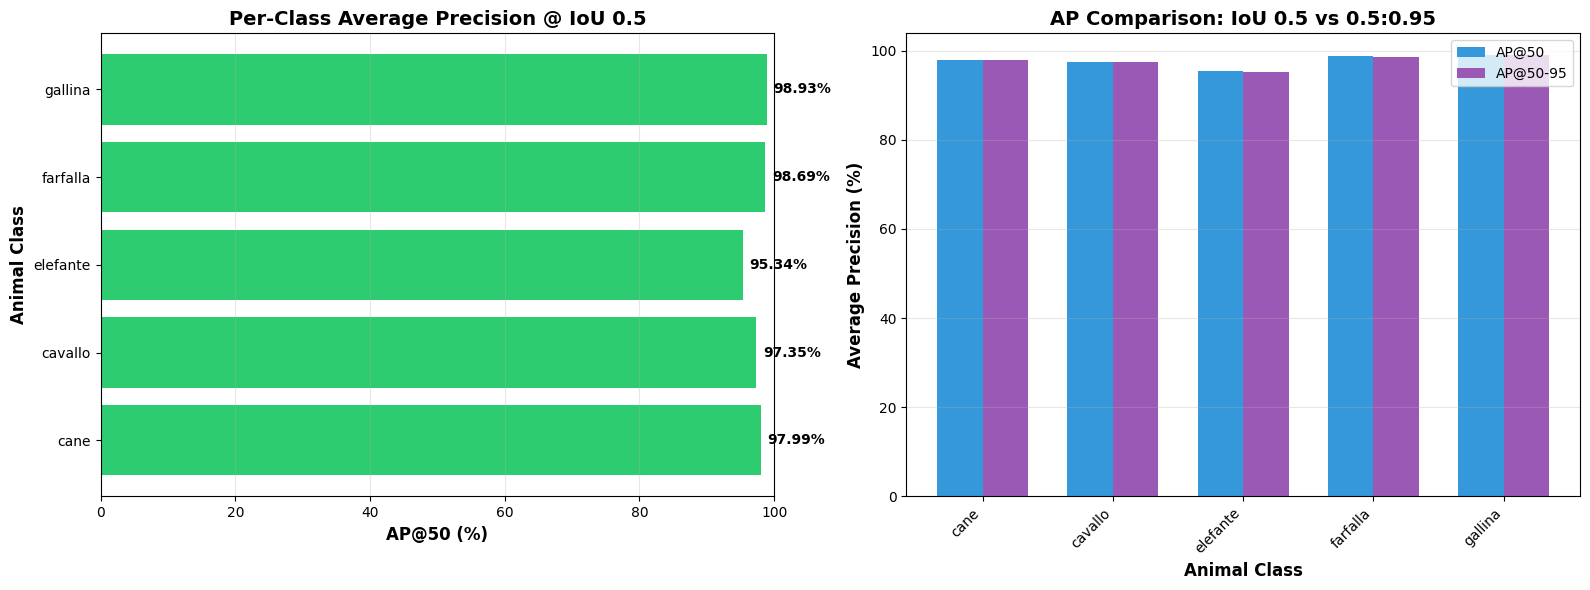

In [25]:
# Generate Per-Class Performance Analysis
print("\n📈 PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 80)

# Extract per-class metrics
class_names = sorted(top_5_classes)
per_class_ap50 = validation_results.box.ap50
per_class_ap = validation_results.box.ap

# Create per-class performance table
per_class_data = []
for idx, class_name in enumerate(class_names):
    per_class_data.append({
        'Class': class_name,
        'AP@50': per_class_ap50[idx] if idx < len(per_class_ap50) else 0,
        'AP@50-95': per_class_ap[idx] if idx < len(per_class_ap) else 0,
        'Performance': 'Excellent' if (per_class_ap50[idx] if idx < len(per_class_ap50) else 0) > 0.9
                      else 'Good' if (per_class_ap50[idx] if idx < len(per_class_ap50) else 0) > 0.7
                      else 'Fair' if (per_class_ap50[idx] if idx < len(per_class_ap50) else 0) > 0.5
                      else 'Needs Improvement'
    })

per_class_df = pd.DataFrame(per_class_data)

print("\n📋 Per-Class Average Precision (AP) Scores:")
print("-" * 80)
print(per_class_df.to_string(index=False))
print("-" * 80)

# Identify best and worst performing classes
best_class = per_class_df.loc[per_class_df['AP@50'].idxmax()]
worst_class = per_class_df.loc[per_class_df['AP@50'].idxmin()]

print(f"\n🏆 Best Performing Class:")
print(f"   Class: {best_class['Class']}")
print(f"   AP@50: {best_class['AP@50']:.4f}")
print(f"   AP@50-95: {best_class['AP@50-95']:.4f}")

print(f"\n⚠️  Worst Performing Class:")
print(f"   Class: {worst_class['Class']}")
print(f"   AP@50: {worst_class['AP@50']:.4f}")
print(f"   AP@50-95: {worst_class['AP@50-95']:.4f}")
print("=" * 80)

# Visualize per-class performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# AP@50 bar chart
axes[0].barh(per_class_df['Class'], per_class_df['AP@50'] * 100, 
             color=['#2ecc71' if ap > 0.7 else '#f39c12' if ap > 0.5 else '#e74c3c' 
                    for ap in per_class_df['AP@50']])
axes[0].set_xlabel('AP@50 (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Animal Class', fontsize=12, fontweight='bold')
axes[0].set_title('Per-Class Average Precision @ IoU 0.5', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 100)
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (cls, ap) in enumerate(zip(per_class_df['Class'], per_class_df['AP@50'])):
    axes[0].text(ap * 100 + 1, i, f'{ap*100:.2f}%', va='center', fontweight='bold')

# AP comparison chart
x = np.arange(len(class_names))
width = 0.35
axes[1].bar(x - width/2, per_class_df['AP@50'] * 100, width, label='AP@50', color='#3498db')
axes[1].bar(x + width/2, per_class_df['AP@50-95'] * 100, width, label='AP@50-95', color='#9b59b6')
axes[1].set_xlabel('Animal Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Precision (%)', fontsize=12, fontweight='bold')
axes[1].set_title('AP Comparison: IoU 0.5 vs 0.5:0.95', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(per_class_df['Class'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


🔍 CONFUSION MATRIX ANALYSIS

📊 Confusion Matrix (Normalized):
--------------------------------------------------------------------------------


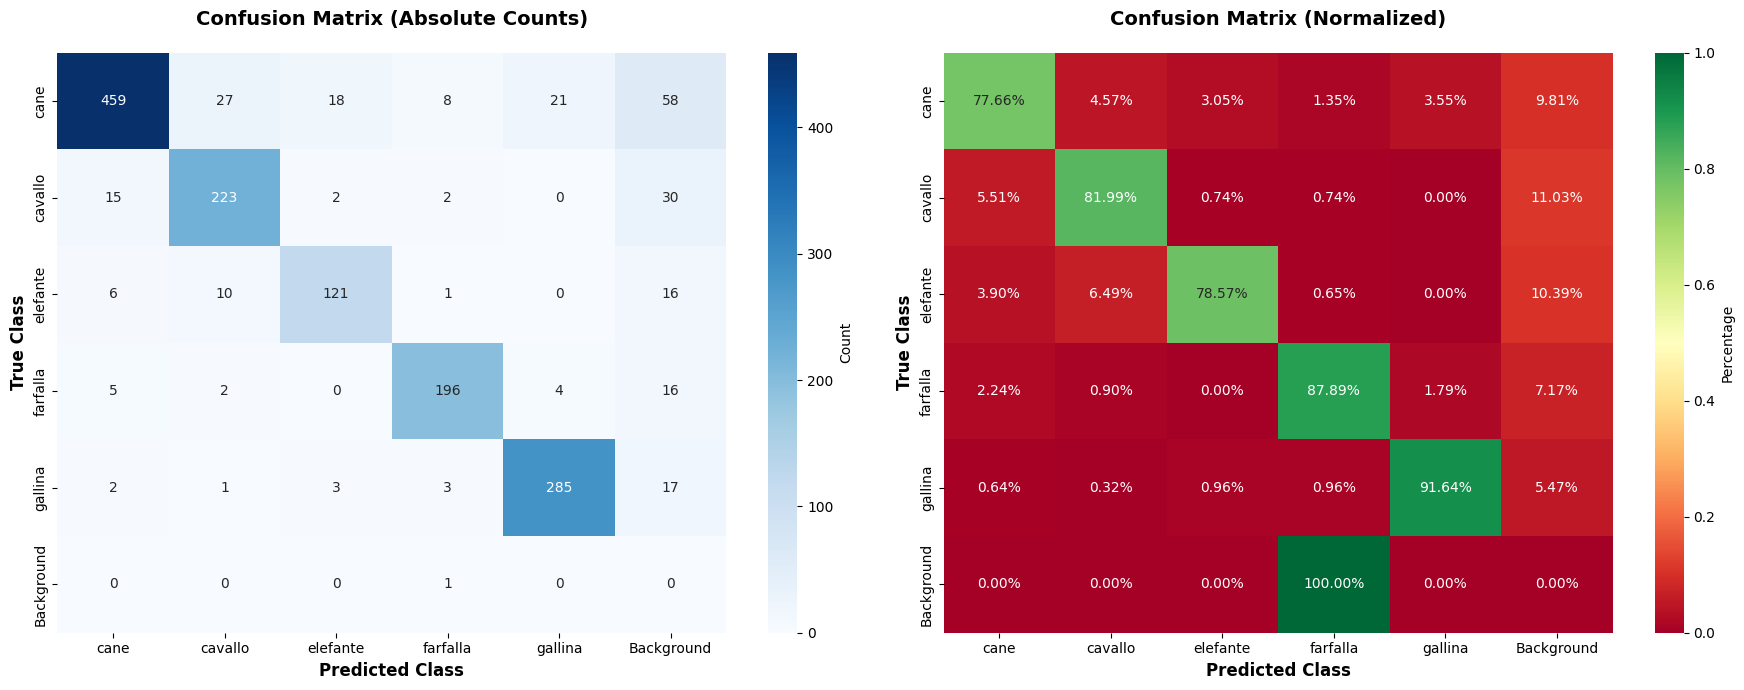


🔎 Misclassification Analysis:
--------------------------------------------------------------------------------
   Top 10 Misclassification Patterns:
True Class Predicted As  Count Percentage
      cane      cavallo     27      4.57%
      cane      gallina     21      3.55%
      cane     elefante     18      3.05%
   cavallo         cane     15      5.51%
  elefante      cavallo     10      6.49%
      cane     farfalla      8      1.35%
  elefante         cane      6      3.90%
  farfalla         cane      5      2.24%
  farfalla      gallina      4      1.79%
   gallina     elefante      3      0.96%
--------------------------------------------------------------------------------


In [26]:
# Create and Visualize Confusion Matrix
print("\n🔍 CONFUSION MATRIX ANALYSIS")
print("=" * 80)

try:
    # Get confusion matrix from validation results
    confusion_matrix = validation_results.confusion_matrix.matrix
    
    # Normalize confusion matrix
    confusion_matrix_norm = confusion_matrix / (confusion_matrix.sum(axis=1, keepdims=True) + 1e-6)
    
    print("\n📊 Confusion Matrix (Normalized):")
    print("-" * 80)
    
    # Create confusion matrix visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot 1: Absolute counts
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', 
                xticklabels=class_names + ['Background'],
                yticklabels=class_names + ['Background'],
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Class', fontsize=12, fontweight='bold')
    axes[0].set_title('Confusion Matrix (Absolute Counts)', fontsize=14, fontweight='bold', pad=20)
    
    # Plot 2: Normalized percentages
    sns.heatmap(confusion_matrix_norm, annot=True, fmt='.2%', cmap='RdYlGn', 
                xticklabels=class_names + ['Background'],
                yticklabels=class_names + ['Background'],
                ax=axes[1], cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
    axes[1].set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Class', fontsize=12, fontweight='bold')
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze misclassification patterns
    print("\n🔎 Misclassification Analysis:")
    print("-" * 80)
    
    misclassifications = []
    for i, true_class in enumerate(class_names):
        for j, pred_class in enumerate(class_names):
            if i != j and confusion_matrix[i, j] > 0:
                misclassifications.append({
                    'True Class': true_class,
                    'Predicted As': pred_class,
                    'Count': int(confusion_matrix[i, j]),
                    'Percentage': f"{confusion_matrix_norm[i, j]*100:.2f}%"
                })
    
    if misclassifications:
        misclass_df = pd.DataFrame(misclassifications)
        misclass_df = misclass_df.sort_values('Count', ascending=False).head(10)
        print("   Top 10 Misclassification Patterns:")
        print(misclass_df.to_string(index=False))
    else:
        print("   ✅ No significant misclassifications detected!")
    
    print("-" * 80)
    print("=" * 80)
    
except Exception as e:
    print(f"⚠️  Could not generate confusion matrix: {e}")
    print("=" * 80)


📊 VALIDATION PERFORMANCE CURVES
⚠️  Error displaying plots: 'numpy.ndarray' object has no attribute 'imshow'


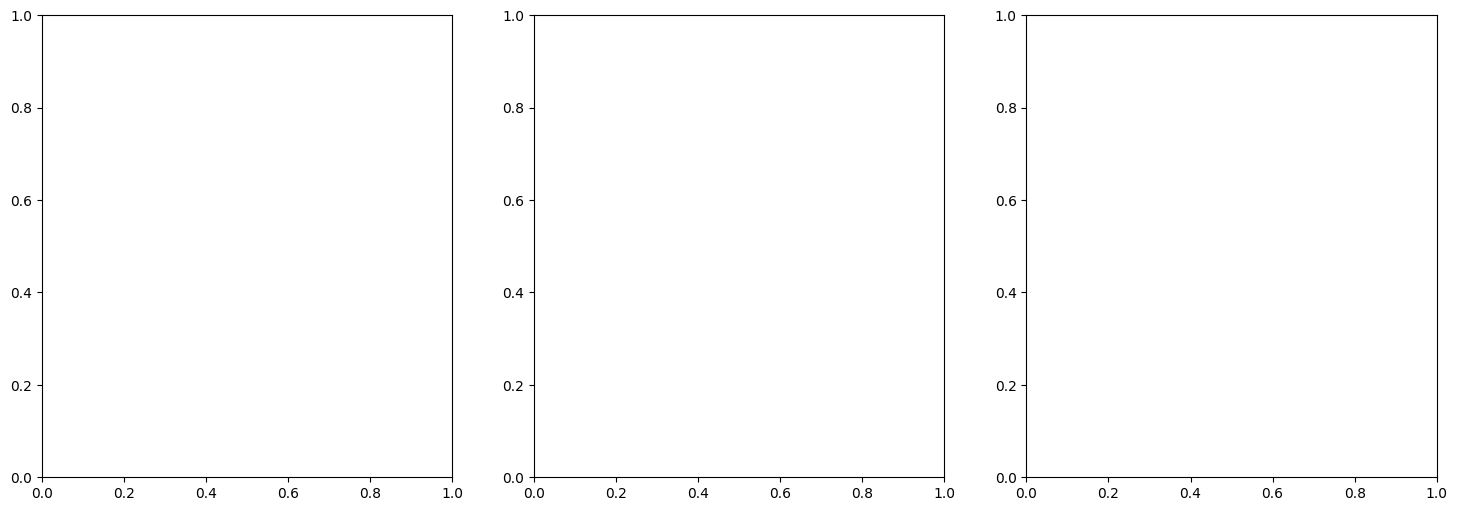

In [27]:
# Display Auto-Generated Validation Plots
print("\n📊 VALIDATION PERFORMANCE CURVES")
print("=" * 80)

try:
    eval_dir = Path('runs/detect/test_evaluation')
    
    # List of validation plots
    plot_files = [
        'confusion_matrix_normalized.png',
        'F1_curve.png',
        'P_curve.png',
        'R_curve.png',
        'PR_curve.png'
    ]
    
    available_plots = []
    for plot_file in plot_files:
        plot_path = eval_dir / plot_file
        if plot_path.exists():
            available_plots.append(plot_path)
    
    if available_plots:
        n_plots = len(available_plots)
        n_cols = 3
        n_rows = (n_plots + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 else axes
        
        for idx, plot_path in enumerate(available_plots):
            img = plt.imread(plot_path)
            axes[idx].imshow(img)
            axes[idx].set_title(plot_path.stem.replace('_', ' ').title(), 
                               fontweight='bold', fontsize=12)
            axes[idx].axis('off')
        
        # Hide unused subplots
        for idx in range(len(available_plots), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Displayed {len(available_plots)} validation curves")
    else:
        print("⚠️  No validation plots found")
    
    print("=" * 80)
    
except Exception as e:
    print(f"⚠️  Error displaying plots: {e}")
    print("=" * 80)


📊 TEST SET CLASS DISTRIBUTION ANALYSIS

📈 Detection Statistics by Class:
--------------------------------------------------------------------------------


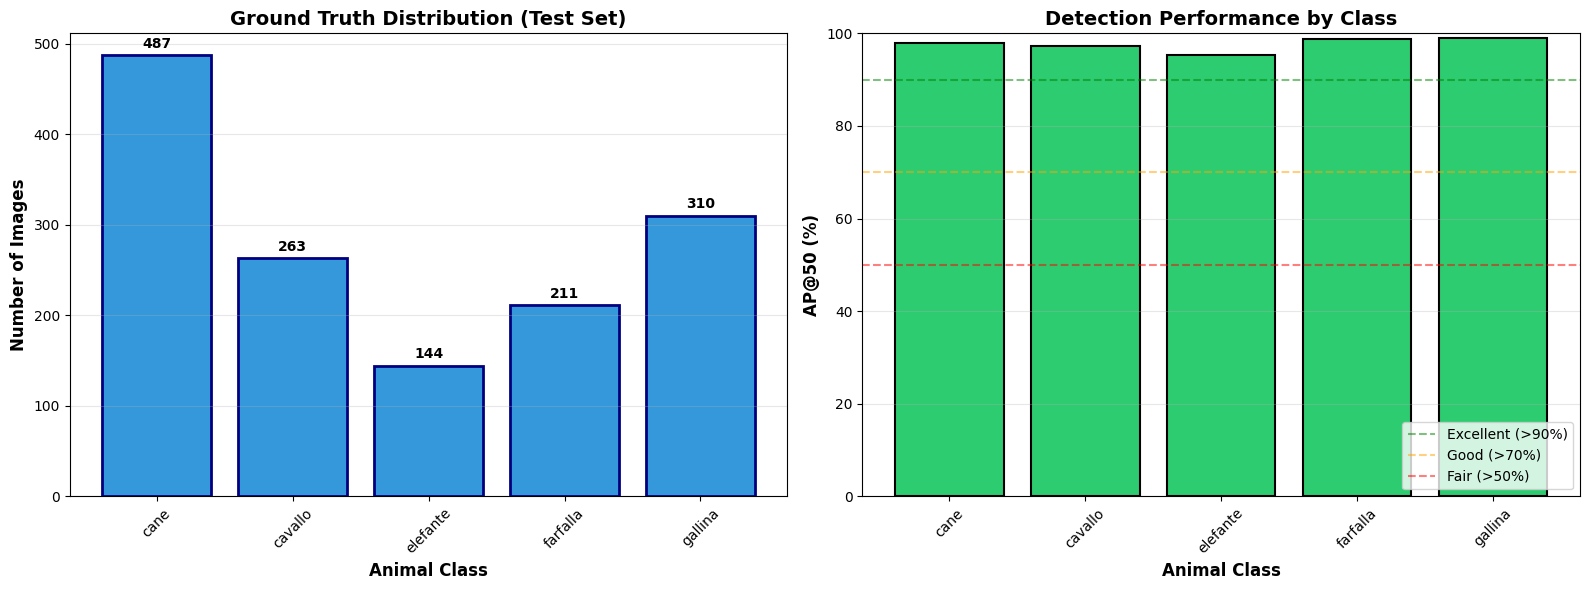


📊 Class Performance Balance:
   Mean AP@50: 0.9766
   Std Dev: 0.0144
   Coefficient of Variation: 1.47%
   ✅ Excellent balance - consistent performance across all classes


In [28]:
# Analyze Class Distribution in Test Results
print("\n📊 TEST SET CLASS DISTRIBUTION ANALYSIS")
print("=" * 80)

# Calculate detection statistics per class
print("\n📈 Detection Statistics by Class:")
print("-" * 80)

# Create distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ground truth distribution
test_df_class_counts = test_df['class'].value_counts().sort_index()
axes[0].bar(test_df_class_counts.index, test_df_class_counts.values, 
           color='#3498db', edgecolor='navy', linewidth=2)
axes[0].set_xlabel('Animal Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Ground Truth Distribution (Test Set)', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (cls, count) in enumerate(test_df_class_counts.items()):
    axes[0].text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Performance by class
axes[1].bar(per_class_df['Class'], per_class_df['AP@50'] * 100,
           color=['#2ecc71' if ap > 0.7 else '#f39c12' if ap > 0.5 else '#e74c3c' 
                  for ap in per_class_df['AP@50']], edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Animal Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AP@50 (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Detection Performance by Class', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 100)

# Add performance threshold lines
axes[1].axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Excellent (>90%)')
axes[1].axhline(y=70, color='orange', linestyle='--', alpha=0.5, label='Good (>70%)')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Fair (>50%)')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Check for class bias
ap_std = per_class_df['AP@50'].std()
ap_mean = per_class_df['AP@50'].mean()

print(f"\n📊 Class Performance Balance:")
print(f"   Mean AP@50: {ap_mean:.4f}")
print(f"   Std Dev: {ap_std:.4f}")
print(f"   Coefficient of Variation: {(ap_std/ap_mean)*100:.2f}%")

if ap_std < 0.1:
    print("   ✅ Excellent balance - consistent performance across all classes")
elif ap_std < 0.15:
    print("   ✓ Good balance - minor variations between classes")
else:
    print("   ⚠️  Significant performance variance - some classes need improvement")

print("=" * 80)

In [29]:
# Generate Performance Summary Report
print("\n📋 PERFORMANCE SUMMARY REPORT")
print("=" * 80)

# Overall assessment
overall_map50 = metrics['mAP@50']
if overall_map50 > 0.9:
    assessment = "EXCELLENT"
    color_code = "🟢"
elif overall_map50 > 0.7:
    assessment = "GOOD"
    color_code = "🟡"
elif overall_map50 > 0.5:
    assessment = "FAIR"
    color_code = "🟠"
else:
    assessment = "NEEDS IMPROVEMENT"
    color_code = "🔴"

print(f"\n{color_code} OVERALL ASSESSMENT: {assessment}")
print("-" * 80)

# Model summary
print("\n📊 Model Performance Summary:")
print(f"   • Overall mAP@50: {metrics['mAP@50']:.4f} ({metrics['mAP@50']*100:.2f}%)")
print(f"   • Overall mAP@50-95: {metrics['mAP@50-95']:.4f} ({metrics['mAP@50-95']*100:.2f}%)")
print(f"   • Precision: {metrics['Precision']:.4f}")
print(f"   • Recall: {metrics['Recall']:.4f}")
print(f"   • F1-Score: {metrics['F1-Score']:.4f}")

# Class-wise summary
print("\n📈 Class-wise Performance Breakdown:")
for _, row in per_class_df.iterrows():
    status = "✅" if row['AP@50'] > 0.7 else "⚠️" if row['AP@50'] > 0.5 else "❌"
    print(f"   {status} {row['Class']:.<20} AP@50: {row['AP@50']:.4f} ({row['Performance']})")

# Recommendations
print("\n💡 RECOMMENDATIONS FOR IMPROVEMENT:")
print("-" * 80)

recommendations = []

# Check overall performance
if overall_map50 < 0.8:
    recommendations.append("• Consider training for more epochs to improve overall performance")
    recommendations.append("• Try data augmentation techniques to increase dataset diversity")

# Check class imbalance
if ap_std > 0.15:
    recommendations.append(f"• Address class imbalance - focus on {worst_class['Class']} class")
    recommendations.append("• Collect more training data for underperforming classes")
    recommendations.append("• Apply class weights during training to balance learning")

# Check precision vs recall
if metrics['Precision'] > metrics['Recall'] + 0.1:
    recommendations.append("• Model is conservative - consider lowering confidence threshold")
    recommendations.append("• Add more positive examples during training")
elif metrics['Recall'] > metrics['Precision'] + 0.1:
    recommendations.append("• Model has high false positive rate - increase confidence threshold")
    recommendations.append("• Add hard negative examples during training")

# Check worst performing class
if worst_class['AP@50'] < 0.6:
    recommendations.append(f"• Investigate {worst_class['Class']} class detection failures")
    recommendations.append(f"• Review {worst_class['Class']} annotations for quality issues")
    recommendations.append(f"• Consider increasing image diversity for {worst_class['Class']}")

# General recommendations
if overall_map50 > 0.8:
    recommendations.append("✅ Model performs well - ready for deployment")
    recommendations.append("• Consider model optimization (quantization, pruning) for production")
    recommendations.append("• Test on additional real-world datasets to verify generalization")

if recommendations:
    for rec in recommendations:
        print(f"   {rec}")
else:
    print("   ✅ Model performance is excellent! No immediate improvements needed.")

print("\n" + "=" * 80)


📋 PERFORMANCE SUMMARY REPORT

🟢 OVERALL ASSESSMENT: EXCELLENT
--------------------------------------------------------------------------------

📊 Model Performance Summary:
   • Overall mAP@50: 0.9766 (97.66%)
   • Overall mAP@50-95: 0.9759 (97.59%)
   • Precision: 0.9439
   • Recall: 0.9163
   • F1-Score: 0.9299

📈 Class-wise Performance Breakdown:
   ✅ cane................ AP@50: 0.9799 (Excellent)
   ✅ cavallo............. AP@50: 0.9735 (Excellent)
   ✅ elefante............ AP@50: 0.9534 (Excellent)
   ✅ farfalla............ AP@50: 0.9869 (Excellent)
   ✅ gallina............. AP@50: 0.9893 (Excellent)

💡 RECOMMENDATIONS FOR IMPROVEMENT:
--------------------------------------------------------------------------------
   ✅ Model performs well - ready for deployment
   • Consider model optimization (quantization, pruning) for production
   • Test on additional real-world datasets to verify generalization



# Interface & Visualization

In [30]:
# PHASE 4: Inference & Visualization

print("=" * 80)
print("🎨 PHASE 4: INFERENCE & VISUALIZATION")
print("=" * 80)
print("\nThis phase will:")
print("   1. Load the best trained model")
print("   2. Select sample images from all 5 classes")
print("   3. Run inference with confidence threshold")
print("   4. Visualize predictions with bounding boxes")
print("   5. Generate inference statistics")
print("   6. Save annotated results")
print("=" * 80)

# Load Best Trained Model
print("\n📦 Loading Best Trained Model...")
print("=" * 80)

try:
    best_model_path = Path('runs/detect/animal_detection/weights/best.pt')
    
    if not best_model_path.exists():
        raise FileNotFoundError(f"Best model weights not found at {best_model_path}")
    
    # Load the model
    inference_model = YOLO(str(best_model_path))
    
    print("✅ Model loaded successfully!")
    print(f"   Model path: {best_model_path}")
    print(f"   Model size: {best_model_path.stat().st_size / (1024 * 1024):.2f} MB")
    print(f"   Device: {device}")
    print("=" * 80)
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

🎨 PHASE 4: INFERENCE & VISUALIZATION

This phase will:
   1. Load the best trained model
   2. Select sample images from all 5 classes
   3. Run inference with confidence threshold
   4. Visualize predictions with bounding boxes
   5. Generate inference statistics
   6. Save annotated results

📦 Loading Best Trained Model...
✅ Model loaded successfully!
   Model path: runs/detect/animal_detection/weights/best.pt
   Model size: 5.93 MB
   Device: cpu


In [32]:
# Select Sample Test Images from All 5 Classes
print("\n🖼️  SELECTING TEST IMAGES")
print("=" * 80)

# Get test images directory
test_images_dir = base_dir / 'images' / 'test'
test_labels_dir = base_dir / 'labels' / 'test'

# Dictionary to store images per class
class_to_images = {cls: [] for cls in sorted(top_5_classes)}

# Read all test images and their class labels
print("📂 Scanning test directory...")
for img_path in test_images_dir.glob('*.jpg'):
    # Read corresponding label file
    label_path = test_labels_dir / f"{img_path.stem}.txt"
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            # Read first line to get class index
            first_line = f.readline().strip()
            if first_line:
                class_idx = int(first_line.split()[0])
                class_name = sorted(top_5_classes)[class_idx]
                class_to_images[class_name].append(img_path)

# Select 2-3 images from each class (total 10-15 images)
selected_images = []
images_per_class = 3  # Select 3 images per class

print("\n🎯 Selecting sample images from each class:")
print("-" * 80)

for class_name in sorted(top_5_classes):
    available_images = class_to_images[class_name]
    
    if len(available_images) >= images_per_class:
        # Randomly select images
        selected = random.sample(available_images, images_per_class)
        selected_images.extend(selected)
        print(f"   ✓ {class_name:.<20} {len(selected)} images selected")
    else:
        # Use all available images if less than desired
        selected_images.extend(available_images)
        print(f"   ⚠️  {class_name:.<20} {len(available_images)} images (less than {images_per_class})")

print("-" * 80)
print(f"✅ Total selected: {len(selected_images)} images")
print(f"   Breakdown: ~{images_per_class} images × {len(top_5_classes)} classes")
print("=" * 80)

# Sort by class for organized display
selected_images.sort()


🖼️  SELECTING TEST IMAGES
📂 Scanning test directory...

🎯 Selecting sample images from each class:
--------------------------------------------------------------------------------
   ✓ cane................ 3 images selected
   ✓ cavallo............. 3 images selected
   ✓ elefante............ 3 images selected
   ✓ farfalla............ 3 images selected
   ✓ gallina............. 3 images selected
--------------------------------------------------------------------------------
✅ Total selected: 15 images
   Breakdown: ~3 images × 5 classes


In [33]:
# Run Inference on Selected Images
print("\n🔮 RUNNING INFERENCE")
print("=" * 80)

# Create output directory
output_dir = Path('output/predictions')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Output directory: {output_dir}")
print(f"🔧 Inference configuration:")
print(f"   • Confidence threshold: 0.25")
print(f"   • IoU threshold: 0.45")
print(f"   • Image size: 640")
print("=" * 80)

# Run inference
print("\n⏳ Processing images...")
inference_results = []

try:
    results = inference_model.predict(
        source=[str(img) for img in selected_images],
        conf=0.25,
        iou=0.45,
        imgsz=640,
        save=True,
        save_txt=True,
        save_conf=True,
        project='runs/detect',
        name='predictions',
        exist_ok=True,
        device=device,
        verbose=False
    )
    
    # Store results for analysis
    for result in results:
        inference_results.append(result)
    
    print(f"✅ Inference completed on {len(results)} images")
    print(f"📁 Annotated images saved to: runs/detect/predictions/")
    print("=" * 80)
    
except Exception as e:
    print(f"❌ Error during inference: {e}")
    raise


🔮 RUNNING INFERENCE
📁 Output directory: output/predictions
🔧 Inference configuration:
   • Confidence threshold: 0.25
   • IoU threshold: 0.45
   • Image size: 640

⏳ Processing images...
Results saved to /Users/vireakroth/Developer/animal-detection/runs/detect/predictions
15 labels saved to /Users/vireakroth/Developer/animal-detection/runs/detect/predictions/labels
✅ Inference completed on 15 images
📁 Annotated images saved to: runs/detect/predictions/


In [34]:
# Analyze Inference Results
print("\n📊 INFERENCE STATISTICS")
print("=" * 80)

# Initialize statistics
detection_stats = {
    'total_detections': 0,
    'detections_per_class': defaultdict(int),
    'confidence_per_class': defaultdict(list),
    'multi_object_images': 0,
    'no_detection_images': 0
}

# Process each result
print("\n🔍 Processing detection results...")
print("-" * 80)

for idx, (result, img_path) in enumerate(zip(inference_results, selected_images)):
    boxes = result.boxes
    num_detections = len(boxes)
    
    detection_stats['total_detections'] += num_detections
    
    if num_detections == 0:
        detection_stats['no_detection_images'] += 1
    elif num_detections > 1:
        detection_stats['multi_object_images'] += 1
    
    # Analyze each detection
    for box in boxes:
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = sorted(top_5_classes)[class_id]
        
        detection_stats['detections_per_class'][class_name] += 1
        detection_stats['confidence_per_class'][class_name].append(confidence)

print(f"✅ Analysis complete!")
print("=" * 80)

# Display statistics
print("\n📈 Detection Summary:")
print("-" * 80)
print(f"   Total images processed: {len(selected_images)}")
print(f"   Total detections: {detection_stats['total_detections']}")
print(f"   Images with multiple objects: {detection_stats['multi_object_images']}")
print(f"   Images with no detections: {detection_stats['no_detection_images']}")
print(f"   Average detections per image: {detection_stats['total_detections']/len(selected_images):.2f}")

print("\n📊 Detections per Class:")
print("-" * 80)
for class_name in sorted(top_5_classes):
    count = detection_stats['detections_per_class'][class_name]
    if count > 0:
        avg_conf = np.mean(detection_stats['confidence_per_class'][class_name])
        print(f"   {class_name:.<20} {count:>3} detections (avg conf: {avg_conf:.3f})")
    else:
        print(f"   {class_name:.<20} {count:>3} detections")

print("-" * 80)
print("=" * 80)


📊 INFERENCE STATISTICS

🔍 Processing detection results...
--------------------------------------------------------------------------------
✅ Analysis complete!

📈 Detection Summary:
--------------------------------------------------------------------------------
   Total images processed: 15
   Total detections: 16
   Images with multiple objects: 1
   Images with no detections: 0
   Average detections per image: 1.07

📊 Detections per Class:
--------------------------------------------------------------------------------
   cane................   3 detections (avg conf: 0.973)
   cavallo.............   3 detections (avg conf: 0.862)
   elefante............   3 detections (avg conf: 0.910)
   farfalla............   3 detections (avg conf: 0.985)
   gallina.............   4 detections (avg conf: 0.858)
--------------------------------------------------------------------------------



🎨 CREATING VISUALIZATION GRID
🖼️  Creating 4×3 visualization grid...


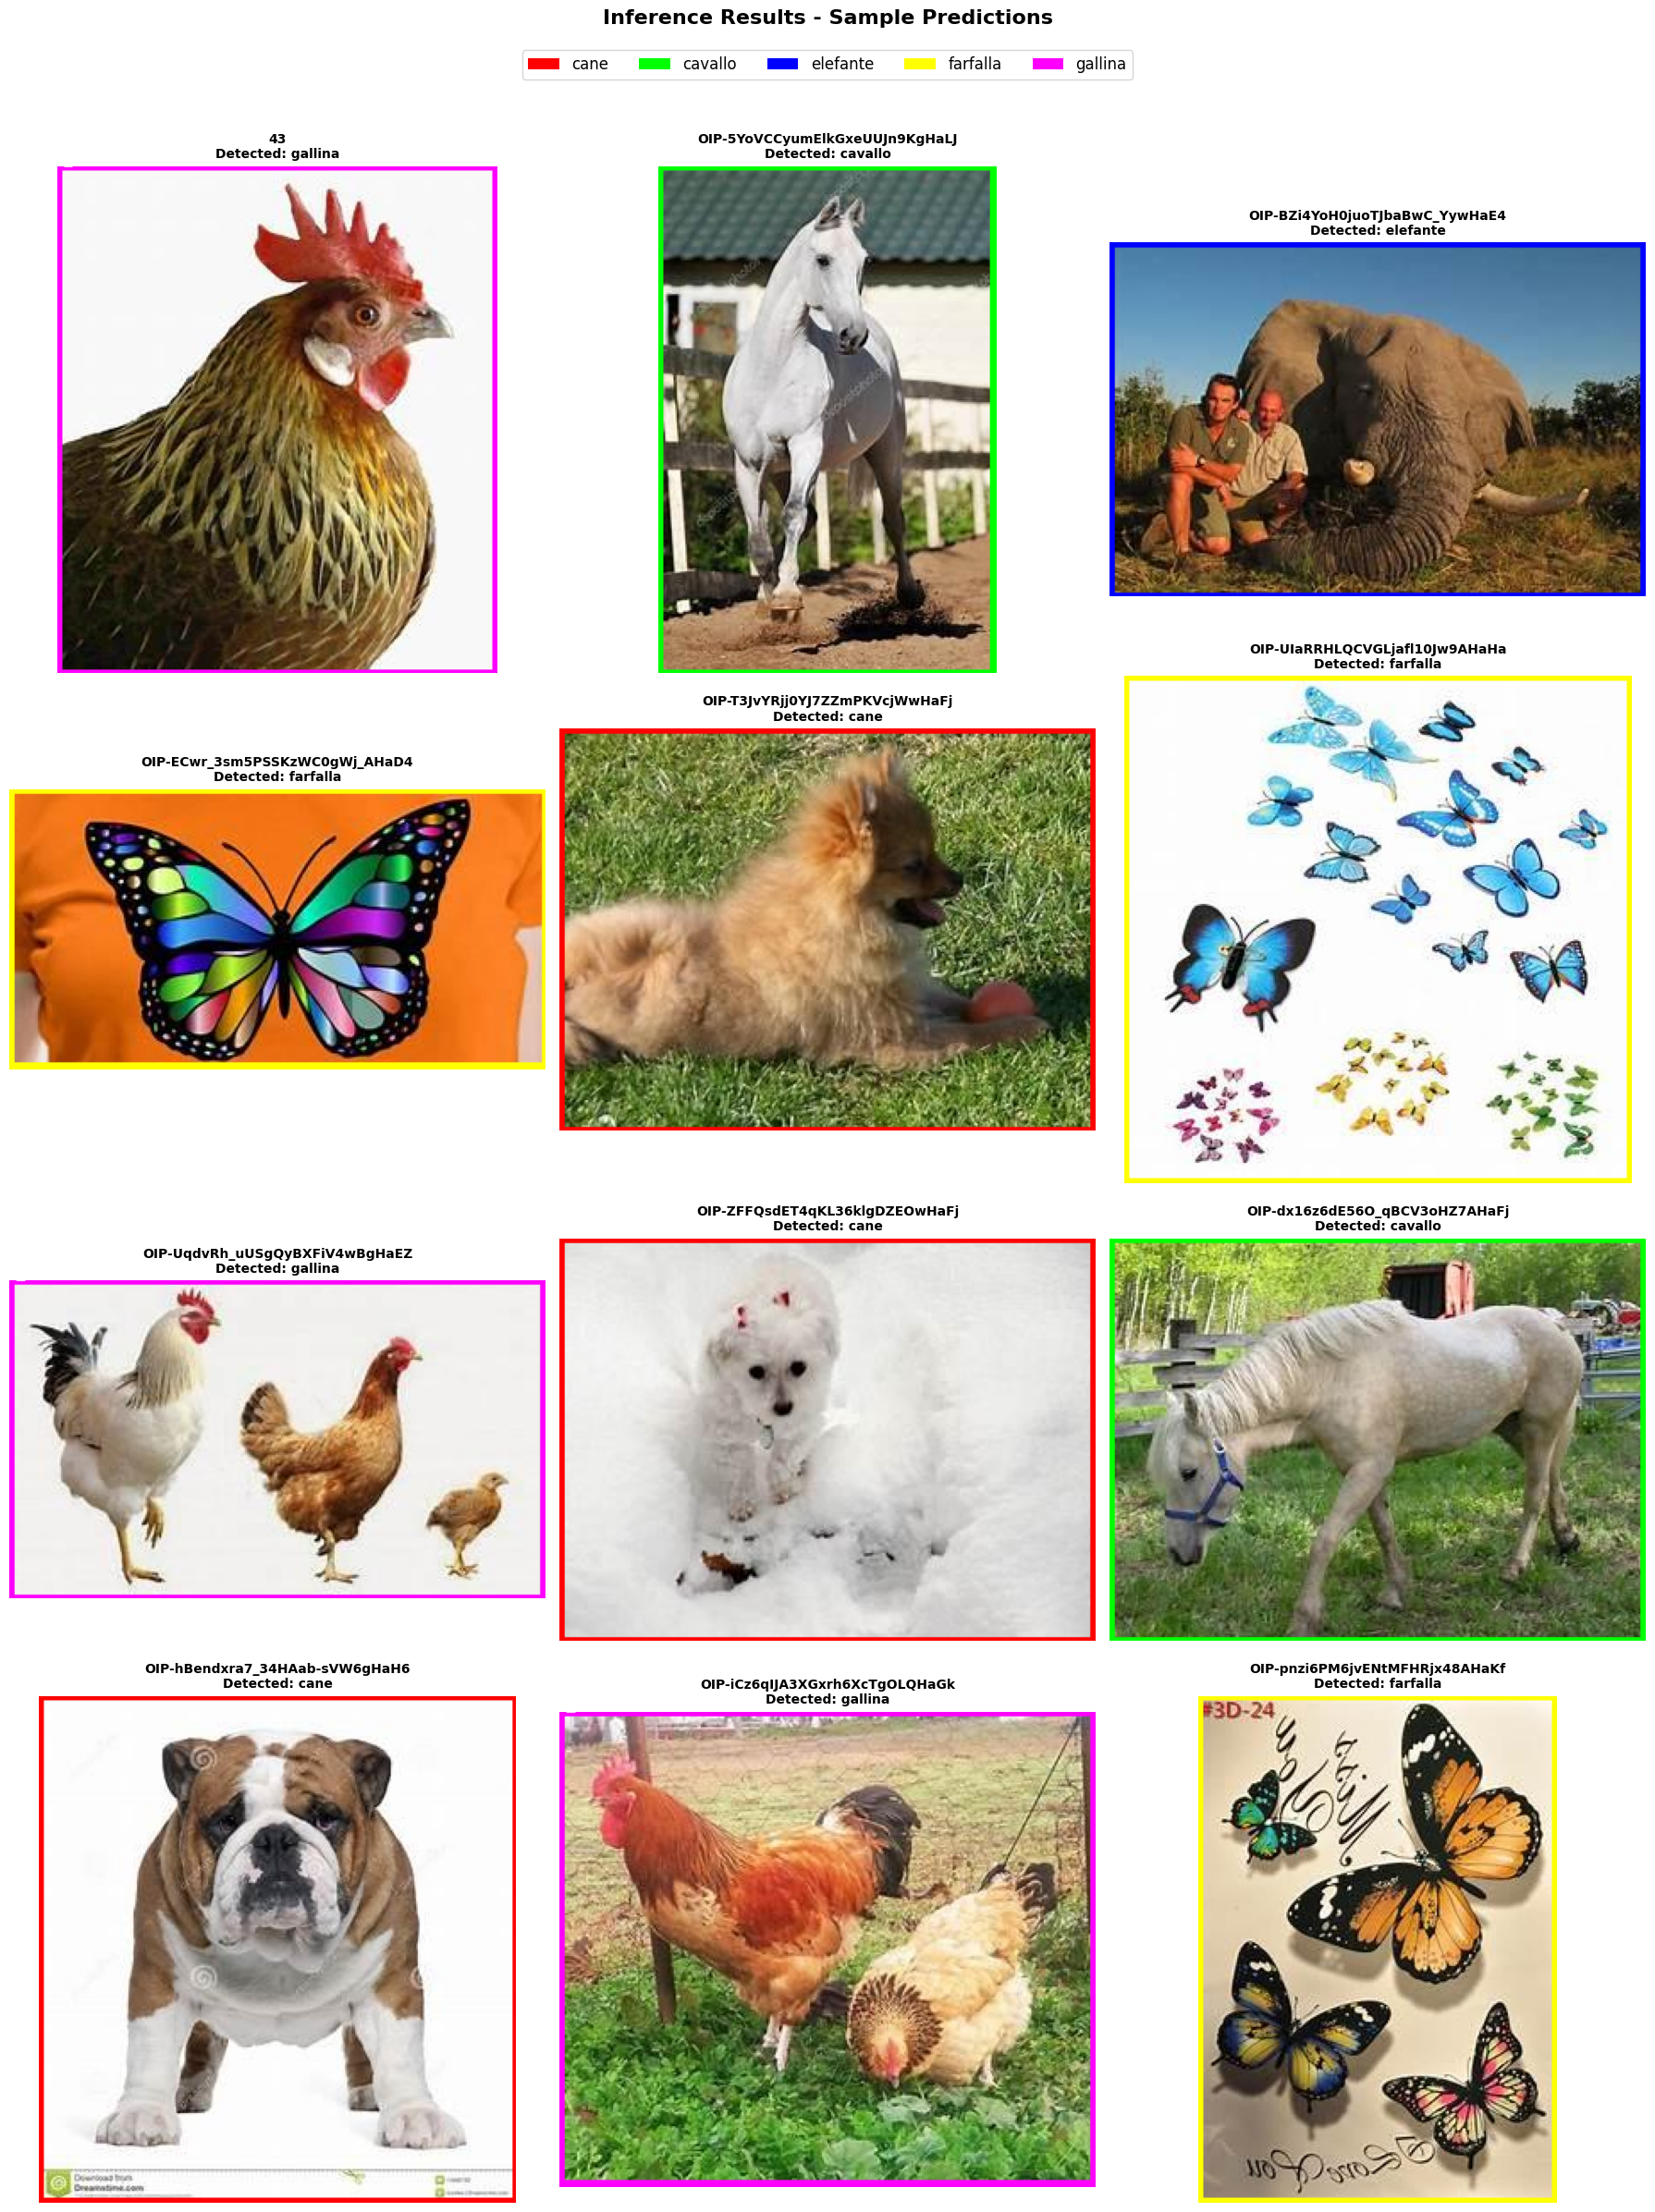

✅ Visualization grid created!


In [35]:
# Visualize Predictions in Grid Layout
print("\n🎨 CREATING VISUALIZATION GRID")
print("=" * 80)

# Define colors for each class
class_colors = {
    sorted(top_5_classes)[0]: (255, 0, 0),      # Red
    sorted(top_5_classes)[1]: (0, 255, 0),      # Green
    sorted(top_5_classes)[2]: (0, 0, 255),      # Blue
    sorted(top_5_classes)[3]: (255, 255, 0),    # Yellow
    sorted(top_5_classes)[4]: (255, 0, 255),    # Magenta
}

# Select subset for visualization (12 images max for clean grid)
vis_images = selected_images[:12]
vis_results = inference_results[:12]

# Create figure with subplots (3 columns × 4 rows)
n_cols = 3
n_rows = (len(vis_images) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

print(f"🖼️  Creating {n_rows}×{n_cols} visualization grid...")

for idx, (img_path, result) in enumerate(zip(vis_images, vis_results)):
    if idx >= len(axes):
        break
    
    # Read original image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img.copy()
    
    # Get detections
    boxes = result.boxes
    
    # Draw bounding boxes
    detected_classes = []
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = sorted(top_5_classes)[class_id]
        detected_classes.append(class_name)
        
        # Get color for this class
        color = class_colors[class_name]
        
        # Draw rectangle
        cv2.rectangle(img_copy, 
                     (int(x1), int(y1)), 
                     (int(x2), int(y2)), 
                     color, 3)
        
        # Create label with class name and confidence
        label = f"{class_name}: {confidence:.2f}"
        
        # Draw label background
        (label_width, label_height), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
        )
        cv2.rectangle(img_copy,
                     (int(x1), int(y1) - label_height - 10),
                     (int(x1) + label_width, int(y1)),
                     color, -1)
        
        # Draw label text
        cv2.putText(img_copy, label,
                   (int(x1), int(y1) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX,
                   0.6, (255, 255, 255), 2)
    
    # Display image
    axes[idx].imshow(img_copy)
    
    # Create title
    filename = img_path.stem
    if detected_classes:
        title = f"{filename}\nDetected: {', '.join(set(detected_classes))}"
    else:
        title = f"{filename}\nNo detections"
    
    axes[idx].set_title(title, fontsize=10, fontweight='bold')
    axes[idx].axis('off')

# Hide unused subplots
for idx in range(len(vis_images), len(axes)):
    axes[idx].axis('off')

# Add legend for class colors
legend_elements = []
for class_name in sorted(top_5_classes):
    color = [c/255 for c in class_colors[class_name]]
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=class_name))

fig.legend(handles=legend_elements, 
          loc='upper center', 
          ncol=5, 
          fontsize=12,
          frameon=True,
          bbox_to_anchor=(0.5, 0.98))

plt.suptitle('Inference Results - Sample Predictions', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("✅ Visualization grid created!")
print("=" * 80)

In [36]:
# Save Annotated Images and Generate Summary Report
print("\n💾 SAVING RESULTS")
print("=" * 80)

# Copy annotated images from runs/detect/predictions/ to output/predictions/
predictions_dir = Path('runs/detect/predictions')
saved_count = 0

print("📂 Copying annotated images to output directory...")

if predictions_dir.exists():
    for img_file in predictions_dir.glob('*.jpg'):
        # Copy to output directory
        output_path = output_dir / img_file.name
        shutil.copy2(img_file, output_path)
        saved_count += 1

print(f"✅ Saved {saved_count} annotated images to: {output_dir}/")

# Generate summary report
summary_file = output_dir / 'inference_summary.txt'

print(f"\n📝 Creating summary report: {summary_file}")

with open(summary_file, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("ANIMAL DETECTION - INFERENCE SUMMARY REPORT\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Model: {best_model_path}\n")
    f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total Images Processed: {len(selected_images)}\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("DETECTION STATISTICS\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Total Detections: {detection_stats['total_detections']}\n")
    f.write(f"Images with Multiple Objects: {detection_stats['multi_object_images']}\n")
    f.write(f"Images with No Detections: {detection_stats['no_detection_images']}\n")
    f.write(f"Average Detections per Image: {detection_stats['total_detections']/len(selected_images):.2f}\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("DETECTIONS PER CLASS\n")
    f.write("=" * 80 + "\n\n")
    
    for class_name in sorted(top_5_classes):
        count = detection_stats['detections_per_class'][class_name]
        if count > 0:
            avg_conf = np.mean(detection_stats['confidence_per_class'][class_name])
            f.write(f"{class_name:.<25} {count:>3} detections (avg confidence: {avg_conf:.3f})\n")
        else:
            f.write(f"{class_name:.<25} {count:>3} detections\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write("DETAILED RESULTS\n")
    f.write("=" * 80 + "\n\n")
    
    for idx, (img_path, result) in enumerate(zip(selected_images, inference_results)):
        f.write(f"\nImage {idx+1}: {img_path.name}\n")
        f.write("-" * 80 + "\n")
        
        boxes = result.boxes
        if len(boxes) == 0:
            f.write("   No detections\n")
        else:
            for box_idx, box in enumerate(boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = sorted(top_5_classes)[class_id]
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                
                f.write(f"   Detection {box_idx+1}:\n")
                f.write(f"      Class: {class_name}\n")
                f.write(f"      Confidence: {confidence:.4f}\n")
                f.write(f"      Bounding Box: ({int(x1)}, {int(y1)}) to ({int(x2)}, {int(y2)})\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write("END OF REPORT\n")
    f.write("=" * 80 + "\n")

print(f"✅ Summary report saved!")
print("=" * 80)

print("\n📊 Files saved:")
print("-" * 80)
print(f"   • Annotated images: {output_dir}/ ({saved_count} files)")
print(f"   • Summary report: {summary_file}")
print(f"   • Ultralytics output: runs/detect/predictions/")
print("-" * 80)
print("=" * 80)


💾 SAVING RESULTS
📂 Copying annotated images to output directory...
✅ Saved 15 annotated images to: output/predictions/

📝 Creating summary report: output/predictions/inference_summary.txt
✅ Summary report saved!

📊 Files saved:
--------------------------------------------------------------------------------
   • Annotated images: output/predictions/ (15 files)
   • Summary report: output/predictions/inference_summary.txt
   • Ultralytics output: runs/detect/predictions/
--------------------------------------------------------------------------------



📊 CREATING STATISTICS VISUALIZATIONS


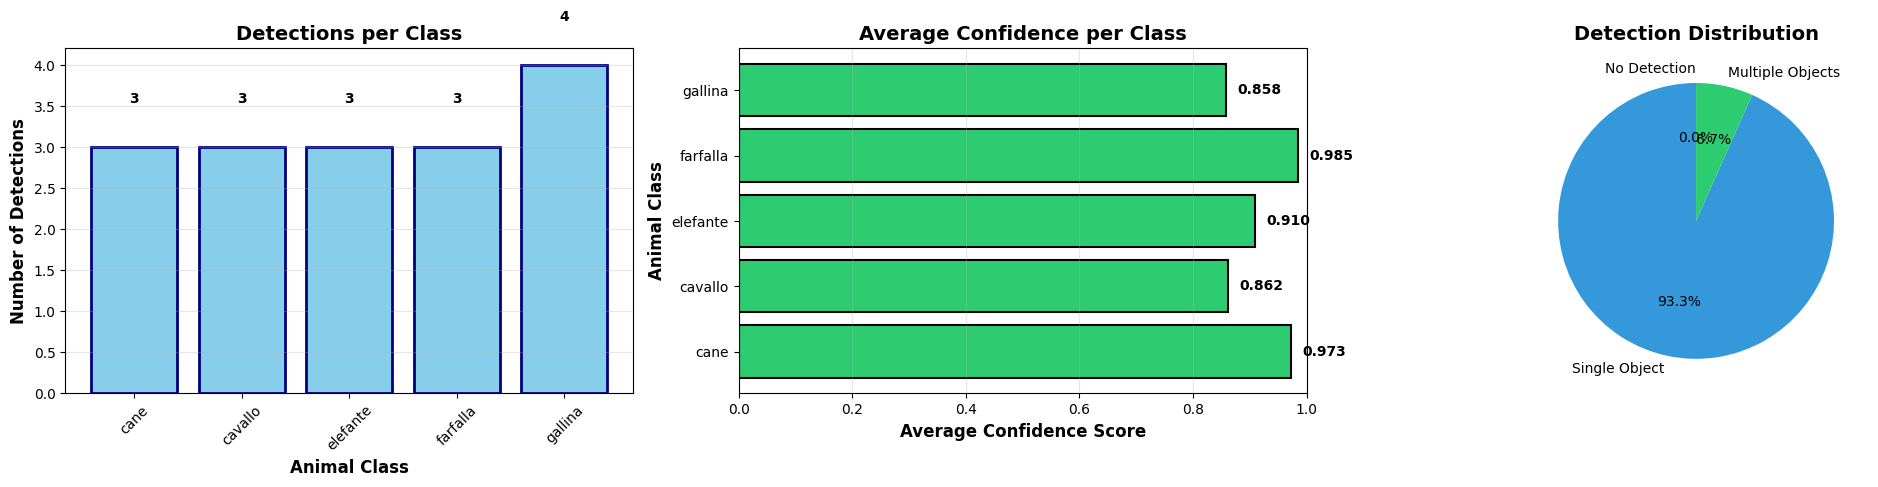

✅ Statistical visualizations created!
📁 Saved to: output/predictions/inference_statistics.png


In [37]:
# Create Statistical Visualizations
print("\n📊 CREATING STATISTICS VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Detections per Class
class_names = sorted(top_5_classes)
detection_counts = [detection_stats['detections_per_class'][cls] for cls in class_names]

axes[0].bar(class_names, detection_counts, color='skyblue', edgecolor='navy', linewidth=2)
axes[0].set_xlabel('Animal Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Detections', fontsize=12, fontweight='bold')
axes[0].set_title('Detections per Class', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (cls, count) in enumerate(zip(class_names, detection_counts)):
    axes[0].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Average Confidence per Class
avg_confidences = []
for cls in class_names:
    if detection_stats['confidence_per_class'][cls]:
        avg_conf = np.mean(detection_stats['confidence_per_class'][cls])
        avg_confidences.append(avg_conf)
    else:
        avg_confidences.append(0)

colors = ['#2ecc71' if conf > 0.7 else '#f39c12' if conf > 0.5 else '#e74c3c' for conf in avg_confidences]
axes[1].barh(class_names, avg_confidences, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Average Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Animal Class', fontsize=12, fontweight='bold')
axes[1].set_title('Average Confidence per Class', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (cls, conf) in enumerate(zip(class_names, avg_confidences)):
    if conf > 0:
        axes[1].text(conf + 0.02, i, f'{conf:.3f}', va='center', fontweight='bold')

# Plot 3: Detection Distribution
detection_types = ['Single Object', 'Multiple Objects', 'No Detection']
detection_values = [
    len(selected_images) - detection_stats['multi_object_images'] - detection_stats['no_detection_images'],
    detection_stats['multi_object_images'],
    detection_stats['no_detection_images']
]

axes[2].pie(detection_values, labels=detection_types, autopct='%1.1f%%', 
           colors=['#3498db', '#2ecc71', '#e74c3c'], startangle=90)
axes[2].set_title('Detection Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'inference_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Statistical visualizations created!")
print(f"📁 Saved to: {output_dir}/inference_statistics.png")
print("=" * 80)

In [38]:
# Test on Custom Images
print("\n🎯 CUSTOM IMAGE INFERENCE (OPTIONAL)")
print("=" * 80)

def run_custom_inference(image_paths, confidence_threshold=0.25):
    """
    Run inference on custom images
    
    Args:
        image_paths: List of image paths or single image path
        confidence_threshold: Confidence threshold for detections
    """
    if isinstance(image_paths, (str, Path)):
        image_paths = [image_paths]
    
    # Validate image paths
    valid_paths = []
    for img_path in image_paths:
        img_path = Path(img_path)
        if img_path.exists() and img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
            valid_paths.append(img_path)
        else:
            print(f"⚠️  Skipping invalid image: {img_path}")
    
    if not valid_paths:
        print("❌ No valid images found!")
        return
    
    print(f"🔮 Running inference on {len(valid_paths)} custom images...")
    print(f"   Confidence threshold: {confidence_threshold}")
    print("-" * 80)
    
    try:
        # Run inference
        results = inference_model.predict(
            source=[str(p) for p in valid_paths],
            conf=confidence_threshold,
            iou=0.45,
            imgsz=640,
            save=True,
            project='runs/detect',
            name='custom_predictions',
            exist_ok=True,
            device=device,
            verbose=False
        )
        
        # Display results
        n_cols = min(3, len(valid_paths))
        n_rows = (len(valid_paths) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
        if len(valid_paths) == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 else axes
        
        for idx, (img_path, result) in enumerate(zip(valid_paths, results)):
            # Read and display image
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Get detections
            boxes = result.boxes
            detected = []
            
            for box in boxes:
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = sorted(top_5_classes)[class_id]
                detected.append(f"{class_name} ({confidence:.2f})")
            
            axes[idx].imshow(img)
            title = f"{img_path.name}\n" + (", ".join(detected) if detected else "No detections")
            axes[idx].set_title(title, fontsize=10, fontweight='bold')
            axes[idx].axis('off')
        
        # Hide unused subplots
        for idx in range(len(valid_paths), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Custom inference complete!")
        print(f"📁 Results saved to: runs/detect/custom_predictions/")
        
    except Exception as e:
        print(f"❌ Error during custom inference: {e}")

# Example usage (uncomment and modify paths to use):
# custom_images = [
#     'path/to/custom/image1.jpg',
#     'path/to/custom/image2.jpg'
# ]
# run_custom_inference(custom_images, confidence_threshold=0.3)

print("💡 To use custom inference:")
print("   1. Uncomment the example code above")
print("   2. Replace paths with your custom image paths")
print("   3. Adjust confidence threshold if needed")
print("   4. Run the cell")
print("=" * 80)


🎯 CUSTOM IMAGE INFERENCE (OPTIONAL)
💡 To use custom inference:
   1. Uncomment the example code above
   2. Replace paths with your custom image paths
   3. Adjust confidence threshold if needed
   4. Run the cell


In [39]:
# Completion Summary
print("\n✅ PHASE 4 COMPLETE: INFERENCE & VISUALIZATION")
print("=" * 80)

print("\n📋 Summary:")
print(f"   ✓ Model loaded: {best_model_path}")
print(f"   ✓ Images processed: {len(selected_images)}")
print(f"   ✓ Total detections: {detection_stats['total_detections']}")
print(f"   ✓ Detection rate: {(len(selected_images) - detection_stats['no_detection_images'])/len(selected_images)*100:.1f}%")
print(f"   ✓ Multi-object detections: {detection_stats['multi_object_images']}")

print("\n📊 Per-Class Performance:")
print("-" * 80)
for class_name in sorted(top_5_classes):
    count = detection_stats['detections_per_class'][class_name]
    if count > 0:
        avg_conf = np.mean(detection_stats['confidence_per_class'][class_name])
        print(f"   {class_name:.<20} {count:>3} detections (avg conf: {avg_conf:.3f})")
    else:
        print(f"   {class_name:.<20} {count:>3} detections")

print("\n💾 Output Files:")
print("-" * 80)
print(f"   ✓ Annotated images: {output_dir}/")
print(f"   ✓ Summary report: {output_dir}/inference_summary.txt")
print(f"   ✓ Statistics plot: {output_dir}/inference_statistics.png")
print(f"   ✓ Ultralytics output: runs/detect/predictions/")

print("\n🎯 Next Steps:")
print("   → Proceed to Phase 5: Documentation & Export")
print("   → Export model to ONNX format")
print("   → Create deployment documentation")
print("   → Generate standalone inference script")
print("=" * 80)


✅ PHASE 4 COMPLETE: INFERENCE & VISUALIZATION

📋 Summary:
   ✓ Model loaded: runs/detect/animal_detection/weights/best.pt
   ✓ Images processed: 15
   ✓ Total detections: 16
   ✓ Detection rate: 100.0%
   ✓ Multi-object detections: 1

📊 Per-Class Performance:
--------------------------------------------------------------------------------
   cane................   3 detections (avg conf: 0.973)
   cavallo.............   3 detections (avg conf: 0.862)
   elefante............   3 detections (avg conf: 0.910)
   farfalla............   3 detections (avg conf: 0.985)
   gallina.............   4 detections (avg conf: 0.858)

💾 Output Files:
--------------------------------------------------------------------------------
   ✓ Annotated images: output/predictions/
   ✓ Summary report: output/predictions/inference_summary.txt
   ✓ Statistics plot: output/predictions/inference_statistics.png
   ✓ Ultralytics output: runs/detect/predictions/

🎯 Next Steps:
   → Proceed to Phase 5: Documentation 

# Export

In [5]:
# Export Model to ONNX Format
print("\n🔄 EXPORTING MODEL TO ONNX FORMAT")
print("=" * 80)

try:
    from ultralytics import YOLO
    from pathlib import Path
    
    best_model_path = Path('runs/detect/animal_detection/weights/best.pt')
    
    if not best_model_path.exists():
        raise FileNotFoundError(f"Best model weights not found at {best_model_path}")
    
    # Load best model
    export_model = YOLO(str(best_model_path))
    
    print("📦 Loaded model for export...")
    print(f"   Model: {best_model_path}")
    
    # Export to ONNX
    print("\n⏳ Exporting to ONNX format (this may take a moment)...")
    onnx_path = export_model.export(
        format='onnx',
        imgsz=640,
        simplify=True,
        opset=12
    )
    
    print(f"✅ Model exported successfully!")
    print(f"   ONNX file: {onnx_path}")
    
    # Verify and show file sizes
    if Path(onnx_path).exists():
        pt_size = best_model_path.stat().st_size / (1024 * 1024)
        onnx_size = Path(onnx_path).stat().st_size / (1024 * 1024)
        
        print("\n📊 Model File Sizes:")
        print(f"   PyTorch (.pt):  {pt_size:.2f} MB")
        print(f"   ONNX (.onnx):   {onnx_size:.2f} MB")
    
    print("=" * 80)
    
except Exception as e:
    print(f"❌ Error exporting model: {e}")


🔄 EXPORTING MODEL TO ONNX FORMAT
📦 Loaded model for export...
   Model: runs/detect/animal_detection/weights/best.pt

⏳ Exporting to ONNX format (this may take a moment)...
Ultralytics 8.3.220 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M2)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/animal_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.9 MB)

ONNX: starting export with onnx 1.19.1 opset 12...
ONNX: slimming with onnxslim 0.1.71...
ONNX: export success ✅ 0.6s, saved as 'runs/detect/animal_detection/weights/best.onnx' (11.7 MB)

Export complete (0.8s)
Results saved to /Users/vireakroth/Developer/animal-detection/runs/detect/animal_detection/weights
Predict:         yolo predict task=detect model=runs/detect/animal_detection/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/animal_detection/weights/best.onnx imgsz=640 data=dataset